![](imagenes/UC_FMRI.jpg)

---

---

***Andres Eduardo Aracena Rangel***

*Estudiante del programa del Magister en Física Médica*

---

---


El siguiente Script de Python forma parte del trabajo especial de grado.

Profesora Guía:

*PhD María Daniela Cornejo*

---

---

&nbsp;
Con referencia:

- [Pagina oficial NIbabel](https://nipy.org/nibabel/index.html) 

Imagenes de fMRI extraidas de OpenNuero:
 
 - [ds002422](https://openneuro.org/datasets/ds002422/versions/1.1.0)
 
---

---

 Acronimos:

- CSF: Cerebrospinal Fluid (*líquido cefalorraquídeo*)
- GM: Gray Matter (*materia gris*)
- WM: White Matter (*materia blanca*)

---

---

NOTA:
Cuando indiquemos imagenes brain o mascaras brain, nos estamos refieriendo a las imagenes o mascaras de csf, wm, gm

---

---

&nbsp;
# Modelos de regresión lineal múltiple en series aleatorias

## Importamos librerias

In [1]:
import time # medir el tiempo de ejecución de nuestros programas
start = time.process_time()
inicio = time.time()

In [2]:
import os # El módulo os nos permite acceder a funcionalidades dependientes del Sistema Operativo
from os.path import join as opj   # Este método concatena varios componentes de ruta con exactamente un separador de directorio(‘/’)
import matplotlib.pyplot as plt   # Permite la generación de gráficos
import pandas as pd               #Biblioteca para manipulación de marcos de datos
import numpy as np
from numpy import random

#Biblioteca para estimar modelos estadísticos y realizar pruebas estadísticas
import statsmodels.api as sm

## Definimos parámetros

In [3]:
'''
Ruta donde reposan las series promedios 'brain' y 'series aleatorias' en archivo csv
'''
path_series = '/home/aracena/thesis_ds002422/04_fase2_promedio_series_tiempo_brain/output/0.95/archivos_csv/' 

'''
Ruta donde se guardaran resultados
'''
path_exp = '/home/aracena/thesis_ds002422/05_fase3_validacion_aic_regre_lin_ser_random/'
path_out = opj(path_exp, 'output')
path_png = opj(path_out, 'archivos_png')

'''
Creamos la carpeta de salida
'''
os.system('mkdir -p %s'%path_out);
os.system('mkdir -p %s'%path_png);

## Funciones

### Función para graficar series de tiempo

In [4]:
'''
Función grafica las series de tiempo de una DF introducida. Se requiere input:

- df_data = Dataframe que contiene las series de tiempo
- name_save = nombre con que desea guardar el grafico
'''

def plot_series_time(df_data, resaltar, titulo, name_save): 
    # Creamos una lista con las claves del diccionario ingresado
    tejido = list(df_data.keys())
    # definimos una ventana
    vent_min = 50
    vent_max = 75


    font1 = {'fontsize':14, 'fontweight':'bold', 'color':'tab:blue'}
    font2  = {'fontsize':18, 'fontweight':'bold', 'color':'tab:red'}

    fig, ax = plt.subplots(figsize = (17,8))
    for i,tisue in enumerate(tejido):
        if resaltar[0] == 'all':
            ax.plot(df_data[tisue], linewidth=2, label=tisue)
        elif i < len(resaltar):
            ax.plot(df_data[resaltar[i]], linewidth=2, label=tisue)
        else:           
            ax.plot(df_data[tisue], linewidth=1, label=tisue)

    ax.legend()
    ax.set_xlabel('Tiempo ($\\tau_N$)',fontdict=font1)
    ax.set_ylabel('Señal fMRI',fontdict=font1)
    ax.set_title(titulo, fontdict = font2)
    ax.grid(axis = 'x', color = 'gray', linestyle = 'dashed')
    ax.grid(axis = 'y', color = 'gray', linestyle = 'dashed')
    ax.axvspan(vent_min,vent_max, alpha=0.3, facecolor='y')

    plt.savefig(opj(path_png, name_save))

### Función crear lista de las series de un DF (lista de los valores de la columna del DF) y eliminar series

In [5]:
'''
Función  que extrae una lista de los valores de las columnas de un dataframe.

Inputs:

- df: Dataframe que se desea extrae una lista de los valores de las columnas,
- elmiminar: lista de los valores de las columnas del DF que desea eliminar. Se debe ingresar una lista:
        * NO eliminar ningun valor de las columnas DF --> ['none']
        * Elimimnar uno o mas valores de la lista --> ['nombre_1' , 'nombre_2']
        
        LOS VALORES DEBE ESTAR EN FORMATO STRING (entre comillas simples o dobles)

Output:

- list_series: lista de series del DF
'''

def lista_dataframe(df, eliminar):
    # Creamos una lista de las columnas del dataframe
    series = df.columns.values
    list_series = list(series)
    
    tam = len(eliminar)

    if tam == 1:
        if eliminar[0] == 'none':
            list_series
        else:
            list_series.remove(eliminar[0]) 
    if tam != 1:   
        for i in range(tam):
            list_series.remove(eliminar[i])        
    
    return list_series    

### Función de conjunto potencia ó de número de combinaciones

En matemáticas, dado un conjunto $S$, se llama conjunto potencia o conjunto de partes de $S$ (se denota por $P(S)$ o $2^S$) al conjunto formado por todos los subconjuntos posibles de $S$.

Por ejemplo, si $S= {a, b, c}$ entonces el conjunto potencia de $S$ es 

*P(S) = {{ }, {a}, {b}, {c}, {a, b}, {a, c}, {b, c}, {a, b, c} }*

In [6]:
'''
Función para extraer todos los subconjuntos posibles de un conjunto de una lista de entrada.

Inputs:

- lista_conjunto: Lista donde se desea extraer el conjunto potencia
- columnas: Numero de columnas para ordenar las combinaciones/modelos

Output:

- r: Lista de las combinaciones/modelos.
'''

def potencia(list_conjunto):
    '''
    Calcula y devuelve el conjunto potencia del conjunto c.
    En matemáticas, el conjunto potencia de un conjunto dado es otro conjunto 
    formado por todos los subconjuntos del conjunto dado.
    '''
   
    # Número de combinaciones
    if len(list_conjunto) == 0:
        return [[]]
    r = potencia(list_conjunto[:-1])
    
    return r + [s + [list_conjunto[-1]] for s in r]

### Funcion para crear un dataframe de las combinaciones/modelos

In [7]:
'''
Función para visualizar las combinaciones/modelos en un dataframe, para ser incorporada en documentos.

Inputs:

- lista_combi: Lista de combinaciones/modelos 
- columnas: Numero de columnas para ordenar las combinaciones/modelos

Output:

- df_combi: Dataframe con las combinaciones/modelos
'''


def crear_df_combi(lista_combi, columnas):
    combi = lista_combi
    '''
    ordenamos la lista
    '''
    combi.sort()
    
    '''
    Se reescribe el elemento lista de la lista en un solo valor, 
    que es la combinacion/modelo
    '''

    list_combi =[]
    beta = str('$\\beta$')
    for i, co in enumerate(combi):
        modelo= beta+str(0)
        for j, mo in enumerate(combi[i]):
            modelo = modelo + ' + ' + beta + str(j+1) + ' ' + mo
        list_combi.append(modelo)   
    
    '''
    PROCESO DE CONVERTIR DE LISTA 1D A UN DATAFRAME FIL X COLUM
    '''
    # Indique cuantas columnas quiere representar las combinaciones en un DF
    colum = columnas

    # Como se quiere crear una matriz de 'colum' columnas, 
    # verifico si 'long' es divisible entre 'colum'; de no ser serlo, 
    # agrego un elemneto vacio a la lista hasta conseguirlo
    long = len(list_combi)
    n=0
    while n==0:
        if long % colum == 0: 
            n=1
        else:
            list_combi.append('')
            long = len(list_combi)
            
    # Conviertimos la lista en un array
    co = np.array(list_combi)

    # Conviertimos un array de 1D a laa dimension fil x colum
    fil = int(long/colum) # numero de filas

    co = co.reshape(fil,colum)

    # Convertirmos la matriz fil x colum en un DF
    df_combi = pd.DataFrame(co)

    '''
    Cambiamos nombre de columnas
    '''
    #Creamos lista de nuevos nombres
    new_colum = []
    for i in range(colum):
        new_colum.append('Combinaciones / Modelos')

    df_combi.columns = new_colum

    '''
    Renombramos indice
    '''
    #Creamos diccionario de nuevos indices
    new_index = {}
    for i in range(fil):
        new_index[i]= ' '

    #renombramos indices
    df_combi.rename(index=new_index, inplace=True)
    
    return df_combi    

In [8]:
'''
Función para visualizar las combinaciones/modelos en un dataframe, para ser incorporada en documentos.

Inputs:

- lista_combi: Lista de combinaciones/modelos 
- columnas: Numero de columnas para ordenar las combinaciones/modelos

Output:

- df_combi: Dataframe con las combinaciones/modelos
'''


def crear_df_combi_1(lista_combi, columnas):
    '''
    ordenamos la lista
    '''
    combi.sort()
    
    '''
    Se reescribe el elemento lista de la lista en un solo valor, 
    que es la combinacion/modelo
    '''
    le = len(combi)
    list_combi =[]
    for i, co in enumerate(combi):
        ser = co
        w = len(ser)
        for i, se in enumerate(ser):
            if i == 0:
                agr = se
            else:
                agr = agr + ' + ' + se
        list_combi.append(agr)
        
    '''
    PROCESO DE CONVERTIR DE LISTA 1D A UN DATAFRAME FIL X COLUM
    '''
    # Indique cuantas columnas quiere representar las combinaciones en un DF
    colum = columnas

    # Como se quiere crear una matriz de 'colum' columnas, 
    # verifico si 'long' es divisible entre 'colum'; de no ser serlo, 
    # agrego un elemneto vacio a la lista hasta conseguirlo
    long = len(list_combi)
    n=0
    while n==0:
        if long % colum == 0: 
            n=1
        else:
            list_combi.append('')
            long = len(list_combi)
            
    # Conviertimos la lista en un array
    co = np.array(list_combi)

    # Conviertimos un array de 1D a laa dimension fil x colum
    fil = int(long/colum) # numero de filas

    co = co.reshape(fil,colum)

    # Convertirmos la matriz fil x colum en un DF
    df_combi = pd.DataFrame(co)

    '''
    Cambiamos nombre de columnas
    '''
    #Creamos lista de nuevos nombres
    new_colum = []
    for i in range(colum):
        new_colum.append('Combinaciones / Modelos')

    df_combi.columns = new_colum

    '''
    Renombramos indice
    '''
    #Creamos diccionario de nuevos indices
    new_index = {}
    for i in range(fil):
        new_index[i]= ' '

    #renombramos indices
    df_combi.rename(index=new_index, inplace=True)
    
    return df_combi    

### Función aplicacion modelo OLS

In [9]:
'''
df_analisis: Dataframe que contien la serie dependiente (variable dependiente o variable de respuesta)
                y las series predictoras (ariables independientes o variables predictoras)
var_depen: Variable dependiente del dataframe (serie a predecir)
modelo: modelo a predecir la variable dependiente

Output: 

aic, r2, r2_adj, model: estadistios
'''


def estadisticos(df_analisis, var_depen, modelo):
    # Y: normalmente significa la variable respuesta (variable dependiente o variable de respuesta)
    #define response variable
    Y = df_analisis[var_depen]

    # X: usualmente significa nuestras variables de entrada (variables independientes o variables predictoras)
    X = df_analisis[modelo]

    #agregar constante a las variables predictoras [intercepción (beta_0) al modelo]
    X = sm.add_constant(X)

    #ajustamos modelo de regresión
    model = sm.OLS(Y, X).fit()    # sm.OLS(respuesta, entrada)

    #guardamos estadisticos AIC, R2, R2-AJUSTADO
    aic = model.aic
    r2 = model.rsquared
    r2_adj = model.rsquared_adj
    
    return aic, r2, r2_adj, model

### Función para determinar el mejor modelo mediante modelo de regresión OSL

In [10]:
def best_osl(df_depen, df_indep, var_depen, lista_combi):
    num_ser = df_depen.shape[1]

    a = pd.DataFrame()
    b = pd.DataFrame()
    aa = pd.DataFrame()
    bb = pd.DataFrame()
    aaa = pd.DataFrame()
    bbb = pd.DataFrame()
    for i in range(num_ser):
        #creamos una lista que identifica la serie del voxel, con la camtidad de combinaciones
        serie = []
        for j in enumerate(lista_combi):
            serie.append(i)
        #se crea dataframe que identifica voxel en estudio
        df_serie = pd.DataFrame(serie, columns=['serie'])

        #extraemos la serie de tiempo del voxel i
        serie_estudio = df_depen.iloc[:,[i]]
        serie_estudio.columns=[var_depen]

        analisis = pd.merge(serie_estudio, df_indep,
                               right_index=True,left_index=True)

        #Ejecutamos la funcion aic
        RESULTADO_AIC = {}
        RESULTADO_R2 = {}
        RESULTADO_R2_AJU = {}
        modelo = {}
        for i, c in enumerate(lista_combi):
            li = lista_combi[i]
            anali = estadisticos(df_analisis=analisis,
                                 var_depen= var_depen,
                                 modelo=li)
            AIC = round(anali[0],2)
            R2 = round(anali[1],4)
            R2_AJU = round(anali[2],4)        
            c = ','.join(c)
            RESULTADO_AIC[c] = AIC
            RESULTADO_R2[c] = R2
            RESULTADO_R2_AJU[c] = R2_AJU
            modelo[c] = anali[3]


        '''
        DataFrame AIC
        '''
        #representamos el resultado aic en un dataframe
        DF_AIC = pd.DataFrame(list(RESULTADO_AIC.items()),
                       columns=['MODELO', 'AIC'])

        #representamos el resultado del modelo(resultado de la regresión
        # lineal) en un dataframe
        DF_MODELO = pd.DataFrame(list(modelo.items()),
                       columns=['MODELO', 'resultado_regresión'])

        # Unimos DF de resultado aic con DF modelo
        DF_AIC = pd.merge(DF_AIC,DF_MODELO, on='MODELO')

        #ordenamos de mayor a menor
        DFM_AIC = DF_AIC.sort_values('AIC')

        #restablecer el índice (para poder eliminar luego los dos ultimos)
        DFM_AIC.reset_index(drop=True, inplace=True)

        #unimos DFM con la identificacion del voxel
        best_model_aic = pd.merge(df_serie, DFM_AIC,
                           right_index=True,left_index=True)

        #elegimos el mejor modelo del voxel en estudio
        be = 1
        en =  len(lista_combi)
        best_aic = best_model_aic.drop(range(1, en, 1),axis=0)

        if i == 0:
            # creamos a y b para concatenar los demas resultados
            a = best_model_aic
            b = best_aic
        else:
            best_model_aic = pd.concat([a, best_model_aic])
            best_aic = pd.concat([b, best_aic])
            a = best_model_aic
            b = best_aic

        #restablecer el índice
        best_model_aic.reset_index(drop=True, inplace=True)
        best_aic.reset_index(drop=True, inplace=True)


        '''
        DataFrame R2
        '''

        #representamos el resultado aic en un dataframe
        DF_R2 = pd.DataFrame(list(RESULTADO_R2.items()),
                       columns=['MODELO', 'R2'])
        #representamos el resultado del modelo(resultado de la regresión
        # lineal) en un dataframe
        DF_MODELO_R2 = pd.DataFrame(list(modelo.items()),
                       columns=['MODELO', 'resultado_regresión'])

        # Unimos DF de resultado aic con DF modelo
        DF_R2 = pd.merge(DF_R2,DF_MODELO_R2, on='MODELO')


        #ordenamos de mayor a menor
        DFM_R2 = DF_R2.sort_values('R2',ascending=False)

        #restablecer el índice (para poder eliminar luego los dos ultimos)
        DFM_R2.reset_index(drop=True, inplace=True)

        #unimos DFM con la identificacion del voxel
        best_model_r2 = pd.merge(df_serie, DFM_R2,
                           right_index=True,left_index=True)

        #elegimos el mejor modelo del voxel en estudio
        be = 1
        en =  len(lista_combi)
        best_r2 = best_model_r2.drop(range(1, en, 1),axis=0)

        if i == 0:
            # creamos a y b para concatenar los demas resultados
            aa = best_model_r2
            bb = best_r2
        else:
            best_model_r2 = pd.concat([aa, best_model_r2])
            best_r2 = pd.concat([bb, best_r2])
            aa = best_model_r2
            bb = best_r2

        #restablecer el índice
        best_model_r2.reset_index(drop=True, inplace=True)
        best_r2.reset_index(drop=True, inplace=True)


        '''
        DataFrame R2-ajustado
        '''
        #representamos el resultado aic en un dataframe
        DF_R2_AJU = pd.DataFrame(list(RESULTADO_R2_AJU.items()),
                       columns=['MODELO', 'R2-ajus'])

        #representamos el resultado del modelo(resultado de la regresión
        # lineal) en un dataframe
        DF_MODELO_R2_AJU = pd.DataFrame(list(modelo.items()),
                       columns=['MODELO', 'resultado_regresión'])

        # Unimos DF de resultado aic con DF modelo
        DF_R2_AJU= pd.merge(DF_R2_AJU,DF_MODELO_R2_AJU, on='MODELO')

        #ordenamos de mayor a menor
        DFM_R2_AJU = DF_R2_AJU.sort_values('R2-ajus',ascending=False)

        #restablecer el índice (para poder eliminar luego los dos ultimos)
        DFM_R2_AJU.reset_index(drop=True, inplace=True)

        #unimos DFM con la identificacion del voxel
        best_model_aju = pd.merge(df_serie, DFM_R2_AJU,
                           right_index=True,left_index=True)

        #elegimos el mejor modelo del voxel en estudio
        be = 1
        en =  len(lista_combi)
        best_r2_aju = best_model_aju.drop(range(1, en, 1),axis=0)

        if i == 0:
            # creamos a y b para concatenar los demas resultados
            aaa = best_model_aju
            bbb = best_r2_aju
        else:
            best_model_aju = pd.concat([aaa, best_model_aju])
            best_r2_aju = pd.concat([bbb, best_r2_aju])
            aaa = best_model_aju
            bbb = best_r2_aju

        #restablecer el índice
        best_model_aju.reset_index(drop=True, inplace=True)
        best_r2_aju.reset_index(drop=True, inplace=True)

    return  best_aic, best_model_aic, best_r2, best_model_r2, best_r2_aju, best_model_aju, 
    #print(DFM_R2)
    #print('\n',best_model)
    #print('\n', best_aic)

### Función para extraer los valores p de los regresores

In [11]:
'''
Función para extraer los valores p de las variables regresoras y su analisis con respecto al nivel 
significancia. Se requiere como inputs:

- df_ana = DF que se desea analisar y que debe contener los resultados de la regresión lineal
- nivel_signif = Nivel de significancia, si es de 5%, ingresamos 0.05, 
                                         si es del 10%, ingresamos 0.1, etc

Como output obtendremos un DF con el analisis sobre el valor p en los regresores
'''


def analisi_p(df_anali, nivel_signif):
    import pandas as pd
    '''
    Extraemos el primer indice de la DF a analizar. Esto se realiza, ya que en el analisis podremos escojer 
    los mejores aic de un conjunto de series que no empiece en el voxel/serie cero, por ejemplo, 
    puedo escojer los voxels del valor 4865 al 9728 que corresponden al segundo corte, y si utilizamos 
    el ciclo for desde 0, nos cambiara la identificación del voxel para para ser ingresado a la DF; 
    por ejemplo, el primer voxel al pasar por el ciclo es el 4865, y el ciclo lo guaradara 
    como 0
    '''

    inicio = df_anali.index.start

    '''
    Extraemos los valores p
    '''
    tam = len(df_anali)

    df_coef = pd.DataFrame()
    df_suma = pd.DataFrame()
    for i in range(tam):
        #extraemos resultados de la regresión lineal (RL) de las series de la imagen
        best_model = df_anali['resultado_regresión'][i+inicio]     
        indice = inicio + i
        #creamos DF de los valores p de la RL de la serie
        df_co = pd.DataFrame(round(best_model.pvalues,2)).T
        df_co.index = [indice]    

        #concatenamos
        df_coef = pd.concat([df_coef,df_co])

        #extraemos nombre de las columnas (regresores) en una lista; se extraee de la lista antes de concaenar
        regresores = df_co.columns.values  
        list_regresor = list(regresores)

        suma_evaluacion = 0
        valores_p = [] # creamos una lista para guardar los valores p y luego anexarla al DF best_aic

        for i, re in enumerate(list_regresor):
            coef = df_coef[re][indice]
            if coef < nivel_signif:
                suma_evaluacion = suma_evaluacion
            else:
                suma_evaluacion = suma_evaluacion + 1

            valores_p.append(coef)

        '''
        Agregamos el resultado de la lista de valores p de los regresores y 
        la suma_evaluación al DF en evaluación
        '''
        df_su = pd.DataFrame()
        df_su['valores_p_regresores'] = [valores_p]
        df_su['suma_evaluación'] = [suma_evaluacion]
        df_su.index = [indice]

        # concatenamos
        df_suma = pd.concat([df_suma,df_su])

    '''
    Unimos en un DF el resultado final
    '''
    analisis_p = pd.merge(df_coef, df_suma,
                       right_index=True,left_index=True)
    '''
    Unimos con la DF analisi_p con la DF de entrada
    '''
    best_p_1 = pd.merge(df_anali, analisis_p,
                           right_index=True,left_index=True)

    # eliminamos la columna resultado_regresión, 
    best_p = best_p_1.drop(['resultado_regresión'], axis=1)
    
    '''
    Crearemos un DF donde anexaremos una nueva columna, donde al evaluar suma_evaluacion si es 0, 
    agregamos el modelo AIC, si es mayor a cero, agregamos la palabra 'Pout', indicandonos que el
    modelo iene un valor p matyor a 0.05
    '''
    modelo_p = pd.DataFrame()

    for i in range(tam):
        valeva = best_p['suma_evaluación'][i+inicio]

        model_p = pd.DataFrame()
        if valeva == 0:
            model_p['MODELO_P'] = [best_p['MODELO'][i+inicio]]
        else:
            model_p['MODELO_P'] = ['Pout']

        model_p.index = [i+inicio]
        modelo_p = pd.concat([modelo_p,model_p])
    '''
    UNIMOS DF
    '''
    df_anali_p = pd.merge(best_p, modelo_p,
                     right_index=True,left_index=True)
    
    return df_anali_p

In [12]:
'''
Función para extraer los valores p de las variables regresoras y su analisis con respecto al nivel 
significancia. Se requiere como inputs:

- df_ana = DF que se desea analisar y que debe contener los resultados de la regresión lineal
- nivel_signif = Nivel de significancia, si es de 5%, ingresamos 0.05, 
                                         si es del 10%, ingresamos 0.1, etc

Como output obtendremos un DF con el analisis sobre el valor p en los regresores
'''


def analisi_p_1(df_anali, nivel_signif):
    import pandas as pd
    '''
    Extraemos el primer indice de la DF a analizar. Esto se realiza, ya que en el analisis podremos escojer 
    los mejores aic de un conjunto de series que no empiece en el voxel/serie cero, por ejemplo, 
    puedo escojer los voxels del valor 4865 al 9728 que corresponden al segundo corte, y si utilizamos 
    el ciclo for desde 0, nos cambiara la identificación del voxel para para ser ingresado a la DF; 
    por ejemplo, el primer voxel al pasar por el ciclo es el 4865, y el ciclo lo guaradara 
    como 0
    '''

    inicio = df_anali.index.start

    '''
    Extraemos los valores p
    '''
    tam = len(df_anali)

    df_coef = pd.DataFrame()
    df_suma = pd.DataFrame()
    for i in range(tam):
        #extraemos resultados de la regresión lineal (RL) de las series de la imagen
        best_model = df_anali['resultado_regresión'][i+inicio]     
        indice = inicio + i
        #creamos DF de los valores p de la RL de la serie
        df_co = pd.DataFrame(round(best_model.pvalues,2)).T
        df_co.index = [indice]   

        #concatenamos
        df_coef = pd.concat([df_coef,df_co])

        #extraemos nombre de las columnas (regresores) en una lista; se extrae de la lista antes de concaenar
        regresores = df_co.columns.values  
        list_regresor = list(regresores)

        suma_evaluacion = 0
        valores_p = [] # creamos una lista para guardar los valores p y luego anexarla al DF best_aic
        
        # El la evaluación, no tomamos en cuenta el valor p de la constante
        for i in range(len(list_regresor)-1):            
            coef = df_coef[list_regresor[i+1]][indice]
            if coef < nivel_signif:
                suma_evaluacion = suma_evaluacion
            else:
                suma_evaluacion = suma_evaluacion + 1

            valores_p.append(coef)

        '''
        Agregamos el resultado de la lista de valores p de los regresores y 
        la suma_evaluación al DF en evaluación
        '''
        df_su = pd.DataFrame()
        df_su['valores_p_regresores_ser'] = [valores_p]
        df_su['suma_evaluación'] = [suma_evaluacion]
        df_su.index = [indice]

        # concatenamos
        df_suma = pd.concat([df_suma,df_su])

    '''
    Unimos en un DF el resultado final
    '''
    analisis_p = pd.merge(df_coef, df_suma,
                       right_index=True,left_index=True)
    '''
    Unimos con la DF analisi_p con la DF de entrada
    '''
    best_p_1 = pd.merge(df_anali, analisis_p,
                           right_index=True,left_index=True)

    # eliminamos la columna resultado_regresión, 
    best_p = best_p_1.drop(['resultado_regresión'], axis=1)
    
    '''
    Crearemos un DF donde anexaremos una nueva columna, donde al evaluar suma_evaluacion si es 0, 
    agregamos el modelo AIC, si es mayor a cero, agregamos la palabra 'Pout', indicandonos que el
    modelo iene un valor p matyor a 0.05
    '''
    modelo_p = pd.DataFrame()

    for i in range(tam):
        valeva = best_p['suma_evaluación'][i+inicio]

        model_p = pd.DataFrame()
        if valeva == 0:
            model_p['MODELO_P'] = [best_p['MODELO'][i+inicio]]
        else:
            model_p['MODELO_P'] = ['Pout']

        model_p.index = [i+inicio]
        modelo_p = pd.concat([modelo_p,model_p])
    '''
    UNIMOS DF
    '''
    df_anali_p = pd.merge(best_p, modelo_p,
                     right_index=True,left_index=True)
    
    return df_anali_p

### Función para graficar la variable dependiente en un modelo de OSL y el resultado del mejor modelo

In [13]:
'''
Función para graficar la variable dependiente en un modelo de OSL y el resultado del mejor modelo 
mediante modelo de regresión OSL.

Inputs:

- df_depen = Dataframe de la variable dependiente del modelo de OSL 
- models_osl = Dataframe de los modelos de regresion al aplicar la funcion 'best_osl'. Ingresar solo
                el resultado segun alguno de los estadistico de AIC, R2 o R2_adjustado.
- best = seleccionar el modelo que quiere graficar. Si desea graficar el mejor modelo, se ingresa 0; 
        si desea graficar el segundo mejor modelo, se ingresa 1, y asi sucesivamente.
- titulo = titulo de la grafica
- name_save = nombre con el que se desea guardar la grafica
'''

def plot_series_osl(df_depen, models_osl, best, titulo, name_save): 
    '''
    Elegimos el modelo segun variable input best
    '''
    best_model= models_osl['resultado_regresión'][best]
    print(best_model.summary())
    
    '''
    Crear la etiqueta del mejor modelo
    '''

    for i, mo in enumerate(models_osl['MODELO'][best]):
        mo=models_osl['MODELO'][best].split(',') #Split regresa una lista de las palabras en la cadena, 
                                 # usando separador como el delimitador.

    '''
    Creamos nombre con los coeficientes y series del mejor modelo
    '''
    beta = str('$\\beta$')
    modelo_win = df_depen.columns.values[0]+' = '+beta+str(0)
    for i, m in enumerate(mo):
        modelo_win = modelo_win + ' + ' + beta + str(i+1) + m 
    
    '''
    Creamos etiqueta de la variable dependiente
    '''
    label_depen = df_depen.columns.values
    label_depen = label_depen[0]
    
    '''
    Dataframe del modelo de regresion OSL
    '''
    df_osl = pd.DataFrame(best_model.fittedvalues)
    df_osl.columns = ['modelo OLS']    
    
    # definimos una ventana
    vent_min = 50
    vent_max = 75


    font1 = {'fontsize':14, 'fontweight':'bold', 'color':'tab:blue'}
    font2  = {'fontsize':18, 'fontweight':'bold', 'color':'tab:red'}

    fig, ax = plt.subplots(figsize = (17,8))
    ax.plot(df_depen, linewidth=2, label=label_depen)
    ax.plot(df_osl, '--.', linewidth=2, color = 'red', label=modelo_win)

    ax.legend()
    ax.set_xlabel('Tiempo ($\\tau_N$)',fontdict=font1)
    ax.set_ylabel('Señal fMRI',fontdict=font1)
    ax.set_title(titulo, fontdict = font2)
    ax.grid(axis = 'x', color = 'gray', linestyle = 'dashed')
    ax.grid(axis = 'y', color = 'gray', linestyle = 'dashed')
    ax.axvspan(vent_min,vent_max, alpha=0.3, facecolor='y')

    plt.savefig(opj(path_png, name_save))

### Función para comparar los modelos segun los estadisticos AIC, R2 Y R2 ajustado

In [14]:
'''
Función que genera un dataframe de comparacion de los modelos segun los estadisticos AIC, R2 Y R2 ajustado.

Inputs:

aic = DF modelos segun el estadistico AIC (DF resultante de la funcion 'best_osl')
r2 = DF modelos segun el estadistico R2 (DF resultante de la funcion 'best_osl')
r2_ajus = DF modelos segun el estadistico R2_ajus (DF resultante de la funcion 'best_osl')
'''

def compara_models_estad(aic,r2,r2_ajus):
    df_aic_best = aic_all.copy()
    df_aic_best = df_aic_best.drop(['serie', 'resultado_regresión'], axis=1)
    
    df_r2_best = r2_all.copy()
    df_r2_best = df_r2_best.drop(['serie', 'resultado_regresión'], axis=1)
    
    df_r2_aju_best = r2_ajus_all.copy()
    df_r2_aju_best = df_r2_aju_best.drop(['serie', 'resultado_regresión'], axis=1)
    
    df4 = pd.merge(df_aic_best,df_r2_best,on='MODELO',how='left')
    df5 = pd.merge(df4,df_r2_aju_best,on='MODELO',how='left')

    df5.style.highlight_max(axis=0)
    
    return     df5.style.\
                    highlight_max(subset=['AIC'], color='salmon').\
                    highlight_min(subset=['AIC'], color='yellow').\
                    highlight_max(subset=['R2','R2-ajus'], color='yellow').\
                    highlight_min(subset=['R2','R2-ajus'], color='salmon').\
                    format({'id':'{:.0f}'})
    

## Generación de una serie de prueba ó serie suma (*ser_sum*)

### Cargamos series *csf* y *gm* promedio

In [15]:
'''
Cargamos la serie del csf
'''
df_csf = pd.read_csv (opj(path_series,'serie_tiempo_val_prom_ser_mask_csf.csv'))

'''
Cargamos la serie del gm
'''
df_gm = pd.read_csv (opj(path_series,'serie_tiempo_val_prom_ser_mask_wm.csv'))

'''
Unimos series csf y gm en un dataframe
'''
df_series_brain = pd.merge(df_csf,df_gm,right_index=True,left_index=True)

df_series_brain.round(3)

ser_mask_csf  ser_mask_wm
0         608.446      545.955
1         607.910      545.948
2         608.437      545.871
3         606.512      545.200
4         607.254      545.471
..            ...          ...
191       608.981      545.935
192       609.086      545.773
193       608.485      545.999
194       608.888      546.369
195       608.049      546.134

[196 rows x 2 columns]

### Extraemos la media de las series  *brain* 

In [16]:
df_mean = pd.DataFrame(df_series_brain.mean())
df_mean.columns = ['mean']
df_mean.round(3)

mean
ser_mask_csf  608.159
ser_mask_wm   545.843

### Creamos dataframe para graficar las series brain con la media

In [17]:
df_mean_csf = pd.DataFrame()

In [18]:
df_mean_csf = pd.DataFrame(columns = ['mean_csf'])

for i in range(df_series_brain['ser_mask_csf'].shape[0]):
    df_mean_csf = df_mean_csf.append({'mean_csf':df_mean['mean']['ser_mask_csf']},                
                   ignore_index = True) 
df_mean_csf

mean_csf
0    608.159373
1    608.159373
2    608.159373
3    608.159373
4    608.159373
..          ...
191  608.159373
192  608.159373
193  608.159373
194  608.159373
195  608.159373

[196 rows x 1 columns]

In [19]:
df_mean_wm = pd.DataFrame(columns = ['mean_wm'])

for i in range(df_series_brain['ser_mask_wm'].shape[0]):
    df_mean_wm = df_mean_wm.append({'mean_wm':df_mean['mean']['ser_mask_wm']},                
                   ignore_index = True) 
df_mean_wm

mean_wm
0    545.8432
1    545.8432
2    545.8432
3    545.8432
4    545.8432
..        ...
191  545.8432
192  545.8432
193  545.8432
194  545.8432
195  545.8432

[196 rows x 1 columns]

In [20]:
'''
Unimos con dDF df_series_brain
'''

df_mean_brains = pd.merge(df_mean_csf,df_mean_wm,right_index=True,left_index=True)
df_series_brain_and_mean = pd.merge(df_series_brain,df_mean_brains,right_index=True,left_index=True)
df_series_brain_and_mean

ser_mask_csf  ser_mask_wm    mean_csf   mean_wm
0      608.445532   545.955034  608.159373  545.8432
1      607.909773   545.948231  608.159373  545.8432
2      608.436558   545.871291  608.159373  545.8432
3      606.512312   545.199905  608.159373  545.8432
4      607.254498   545.471301  608.159373  545.8432
..            ...          ...         ...       ...
191    608.981452   545.935069  608.159373  545.8432
192    609.086091   545.772953  608.159373  545.8432
193    608.484934   545.998505  608.159373  545.8432
194    608.888241   546.368934  608.159373  545.8432
195    608.049152   546.133773  608.159373  545.8432

[196 rows x 4 columns]

### Visualizamos las series  promedio global y sus medias

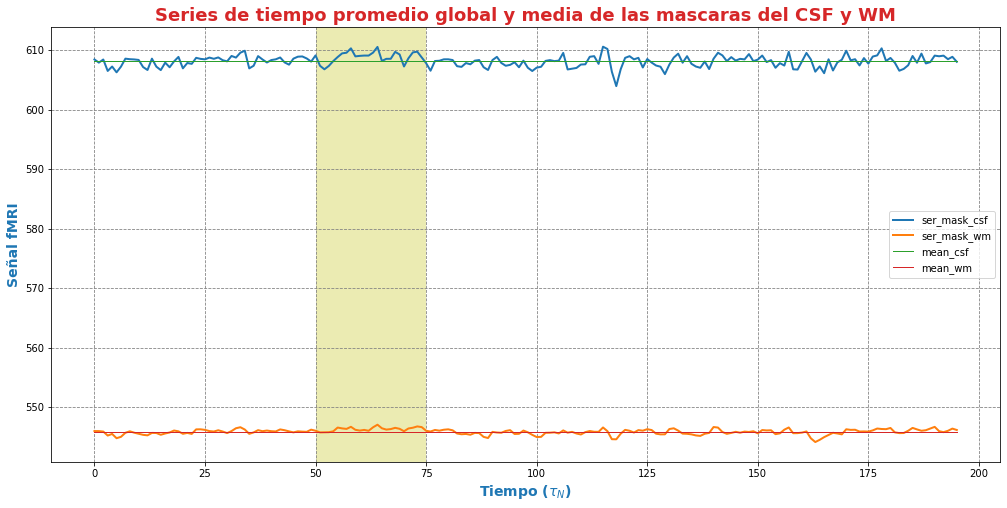

In [21]:
plot_series_time(df_data=df_series_brain_and_mean, 
                 resaltar=['ser_mask_csf', 'ser_mask_wm'], 
                 titulo='Series de tiempo promedio global y media de las mascaras del CSF y WM', 
                 name_save='serie_suma_resultado_random.png')

### Generamos una serie de prueba

La serie de prueba o serie suma (*ser_sum*) esta compuesta por la suma de dos series aleatorias (*ser1* y *ser2*) y una serie de error aleatoria (*error*). La *ser1* se genera con valores aleatorios alrededor de la media de la serie promedio de la mascarara del csf, mientras que la serie *ser2* se genera con valores aleatorios alrededor de la media de la serie promedio de la mascarara del gm. La serie error se genera con valores que se encuentre por debajo de ambas series aleatorias *ser1* y *ser2*.

#### Serie aleatorias *ser1*, *ser2* y *error*

In [22]:
np.random.seed(0) # Usamos una semilla, para evitar que cada vez que ejecutemos el codigo me resulten
                    # series aleatorias distintas, y por motivo que imagenes van en un informe, al no
                    # hacerlo, cada vez que ejecutemos tendremos series distintas y resultados distintos

In [23]:
'''
Creamos series aleatorias ser1 y ser2
'''
ser1 = np.random.uniform(low = int(df_mean['mean']['ser_mask_csf'] - 15), 
                         high = int(df_mean['mean']['ser_mask_csf'] + 15),  
                         size = df_series_brain['ser_mask_csf'].shape[0]).tolist()

ser2 = np.random.uniform(low = int(df_mean['mean']['ser_mask_wm'] - 15), 
                         high = int(df_mean['mean']['ser_mask_wm'] + 15),  
                         size = df_series_brain['ser_mask_wm'].shape[0]).tolist()

'''
Creamos userie error pequena
'''
error = np.random.uniform(low = 80, 
                          high = 100,  
                          size = df_series_brain['ser_mask_csf'].shape[0]).tolist()

In [24]:
'''
Creamos DF de las series aleatorias
'''
df_sr1 = pd.DataFrame(ser1, columns=['ser_1'])
df_sr2 = pd.DataFrame(ser2, columns=['ser_2'])

df_error = pd.DataFrame(error, columns=['error'])

'''
Unimos DFs en una sola
'''
df_ser_random = pd.merge(df_sr1, df_sr2, right_index=True, left_index=True)
df_ser_random = pd.merge(df_ser_random, df_error, right_index=True, left_index=True)
df_ser_random.round(3)

ser_1    ser_2   error
0    609.464  536.822  85.174
1    614.456  537.631  96.981
2    611.083  531.741  80.666
3    609.346  543.032  99.180
4    605.710  539.354  87.107
..       ...      ...     ...
191  599.295  534.782  81.530
192  598.586  548.867  93.929
193  621.331  541.953  84.948
194  615.187  531.881  80.792
195  607.714  542.721  81.199

[196 rows x 3 columns]

#### Serie de prueba o serie suma

In [25]:
'''
la serie suma se compone con la suma de ser1, ser2 y error
'''
df_suma = pd.DataFrame(df_ser_random.sum(axis=1))
df_suma.columns = ['ser_sum']

df_suma

ser_sum
0    1231.460525
1    1249.067142
2    1223.489869
3    1251.558649
4    1232.170897
..           ...
191  1215.607482
192  1241.382006
193  1248.232175
194  1227.860223
195  1231.633618

[196 rows x 1 columns]

#### Unimos df_suma y df_ser_random

In [26]:
df_suma_random = pd.merge(df_suma, df_ser_random, right_index=True, left_index=True)
df_suma_random.round(3)

ser_sum    ser_1    ser_2   error
0    1231.461  609.464  536.822  85.174
1    1249.067  614.456  537.631  96.981
2    1223.490  611.083  531.741  80.666
3    1251.559  609.346  543.032  99.180
4    1232.171  605.710  539.354  87.107
..        ...      ...      ...     ...
191  1215.607  599.295  534.782  81.530
192  1241.382  598.586  548.867  93.929
193  1248.232  621.331  541.953  84.948
194  1227.860  615.187  531.881  80.792
195  1231.634  607.714  542.721  81.199

[196 rows x 4 columns]

#### Damos un formato a las DF solo para ser extraidas a un documento

In [27]:
df_1 = df_suma_random.copy()

new_index = df_1.index+1

nomb_colum = df_1.columns.values

header = pd.MultiIndex.from_product([['Series de tiempo: '], nomb_colum],
                                    names=[' ','tiempo ($\\tau_N$)'])
df_1 = pd.DataFrame(df_1.values, columns=header, index=new_index)

display(df_1.round(3))

Series de tiempo:                           
tiempo ($\tau_N$)            ser_sum    ser_1    ser_2   error
1                           1231.461  609.464  536.822  85.174
2                           1249.067  614.456  537.631  96.981
3                           1223.490  611.083  531.741  80.666
4                           1251.559  609.346  543.032  99.180
5                           1232.171  605.710  539.354  87.107
..                               ...      ...      ...     ...
192                         1215.607  599.295  534.782  81.530
193                         1241.382  598.586  548.867  93.929
194                         1248.232  621.331  541.953  84.948
195                         1227.860  615.187  531.881  80.792
196                         1231.634  607.714  542.721  81.199

[196 rows x 4 columns]

#### Graficamos las series

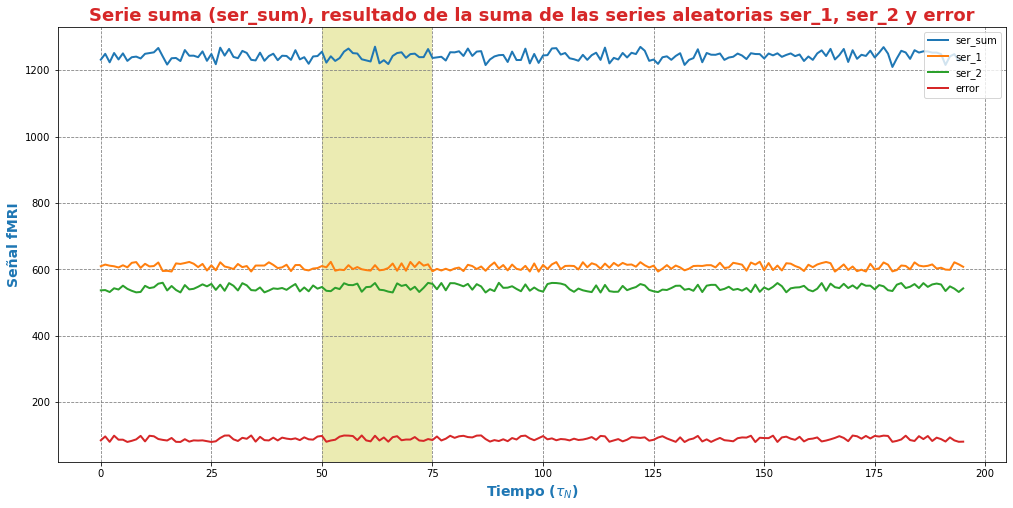

In [28]:
plot_series_time(df_data=df_suma_random, 
                 resaltar=['all'], 
                 titulo='Serie suma (ser_sum), resultado de la suma de las series aleatorias ser_1, ser_2 y error', 
                 name_save='serie_suma_resultado_random.png')

## Validación 1 / Regresión Lineal de series aleatorias


Usaremos el módulo statsmodels de Python para implementar el método Ordinary Least Squares( OLS ) de regresión lineal. Para la primera Validación, usaremos la data de *df_suma_random*, sin agregar series aleatorias adicionales.

### Extraemos las combinaciones

Para extraer las posibles combinaciones o modelos que me pueden predecir la seria suma (*ser_sum*), en esta primera validación (asi como en las posteriores) no tomamos en cuenta en el modelo la serie error (*error*).

#### Lista de series que forman parte de las combinaciones ó modelos

Para extraer la lista que formaran parte de las combionaciones ó modelos, usamos la funcion *lista_dataframe*. Ahora, debemos tener claro que dataframe usaremos como input, para asi poder definir el input de la función *eliminar*. Por ejemplo, si usamos el dataframe *df_ser_random* y no queremos que la serie error sea parte del modelo, el input *eliminar* debe ser la lista *eliminar=['error']*; si usamos el dataframe *df_suma_random* y no queremos que la serie error sea parte del modelo, asi como la *ser_sum* ya que es la que queremos predecir, el input *eliminar* debe ser la lista *eliminar=['ser_sum', 'error']*

In [29]:
'''
Aplicamos funcion lista_dataframe
'''
list_ser = lista_dataframe(df=df_ser_random,
                           eliminar=['error'])

list_ser

['ser_1', 'ser_2']

#### Combinaciones de las series para generar ser_tiem_sum

In [30]:
'''
Posibles combinaciones de las series para generar ser_tiem_sum
'''
#ejecutamos funcion potencia
combi = potencia(list_ser)
combi

[[], ['ser_1'], ['ser_2'], ['ser_1', 'ser_2']]

Como al ejecutar la función potencia, entre los subconjuntos esta el conjunto vacio, lo eliminamos de nuestra lista

In [31]:
'''
Eliminamos primer elemento lista combi
'''
combi.pop(0)

print('posibles combinaciones de las series brain:\n', combi, '\n\n')

print('cantidad de combinaciones/modelos:\n\n', len(combi))

posibles combinaciones de las series brain:
 [['ser_1'], ['ser_2'], ['ser_1', 'ser_2']] 


cantidad de combinaciones/modelos:

 3


#### Generamos un DF de las combinaciones/modelos para un documento

In [32]:
crear_df_combi(lista_combi=combi, 
               columnas = 1)

Combinaciones / Modelos
                    $\beta$0 + $\beta$1 ser_1
   $\beta$0 + $\beta$1 ser_1 + $\beta$2 ser_2
                    $\beta$0 + $\beta$1 ser_2

### Aplicamos el modelo OLS

In [33]:
'''
Creamos DF con las series independientes
'''
df_ser_indep = df_ser_random.drop(['error'], axis=1)
df_ser_indep

ser_1       ser_2
0    609.464405  536.822439
1    614.455681  537.630694
2    611.082901  531.740875
3    609.346495  543.032499
4    605.709644  539.353876
..          ...         ...
191  599.295312  534.782434
192  598.585790  548.866953
193  621.331172  541.953028
194  615.186524  531.881389
195  607.713764  542.720968

[196 rows x 2 columns]

#### Ejecutamos la función  *best_osl*  para determinar el mejor modelo mediante modelo de regresión OSL

In [34]:
modelo_regre = best_osl(df_depen=df_suma, 
                        df_indep=df_ser_indep, 
                        var_depen='ser_sum',
                        lista_combi=combi)

In [35]:
mejor_aic = modelo_regre[0]
aic_all = modelo_regre[1]
mejor_r2 = modelo_regre[2]
r2_all = modelo_regre[3]
mejor_r2_ajus = modelo_regre[4]
r2_ajus_all = modelo_regre[5]

In [36]:
mejor_aic

serie       MODELO      AIC  \
0      0  ser_1,ser_2  1263.62   

                                 resultado_regresión  
0  <statsmodels.regression.linear_model.Regressio...

In [37]:
pd.set_option('display.max_colwidth', 60)
aic_all

serie       MODELO      AIC  \
0      0  ser_1,ser_2  1263.62   
1      0        ser_2  1453.79   
2      0        ser_1  1497.42   

                                           resultado_regresión  
0  <statsmodels.regression.linear_model.RegressionResultsWr...  
1  <statsmodels.regression.linear_model.RegressionResultsWr...  
2  <statsmodels.regression.linear_model.RegressionResultsWr...

#### Aplicamos función *analisi_p* para extraer los valores p de los regresores, y confirmar mejor modelo

In [38]:
analisi_p(df_anali=mejor_aic, 
          nivel_signif=0.05)

serie       MODELO      AIC  const  ser_1  ser_2 valores_p_regresores  \
0      0  ser_1,ser_2  1263.62   0.01    0.0    0.0     [0.01, 0.0, 0.0]   

   suma_evaluación     MODELO_P  
0                0  ser_1,ser_2

#### Graficamos la serie suma y el resultado del mejor modelo mediante modelo de regresión OSL

                            OLS Regression Results                            
Dep. Variable:                ser_sum   R-squared:                       0.786
Model:                            OLS   Adj. R-squared:                  0.783
Method:                 Least Squares   F-statistic:                     353.4
Date:                Tue, 05 Jul 2022   Prob (F-statistic):           3.03e-65
Time:                        01:03:48   Log-Likelihood:                -628.81
No. Observations:                 196   AIC:                             1264.
Df Residuals:                     193   BIC:                             1273.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        116.3428     42.874      2.714      0.0

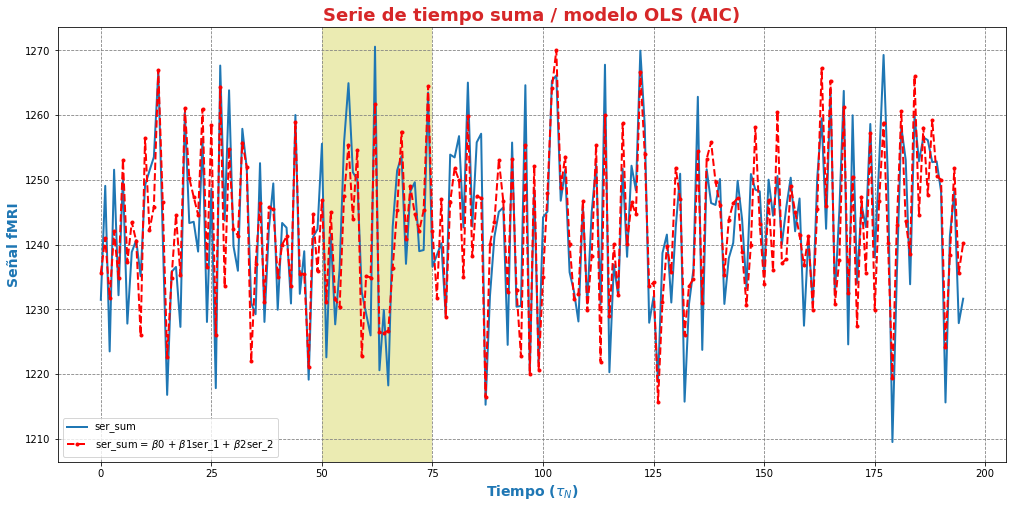

In [39]:
plot_series_osl(df_depen=df_suma, 
                models_osl=aic_all, 
                best=0, 
                titulo='Serie de tiempo suma / modelo OLS (AIC)', 
                name_save='serie_suma_model_ols_aic.png')

#### Graficamos la serie suma y el resultado del segundo mejor modelo mediante modelo de regresión OSL

                            OLS Regression Results                            
Dep. Variable:                ser_sum   R-squared:                       0.428
Model:                            OLS   Adj. R-squared:                  0.425
Method:                 Least Squares   F-statistic:                     145.3
Date:                Tue, 05 Jul 2022   Prob (F-statistic):           2.44e-25
Time:                        01:03:49   Log-Likelihood:                -724.89
No. Observations:                 196   AIC:                             1454.
Df Residuals:                     194   BIC:                             1460.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        715.4023     43.750     16.352      0.0

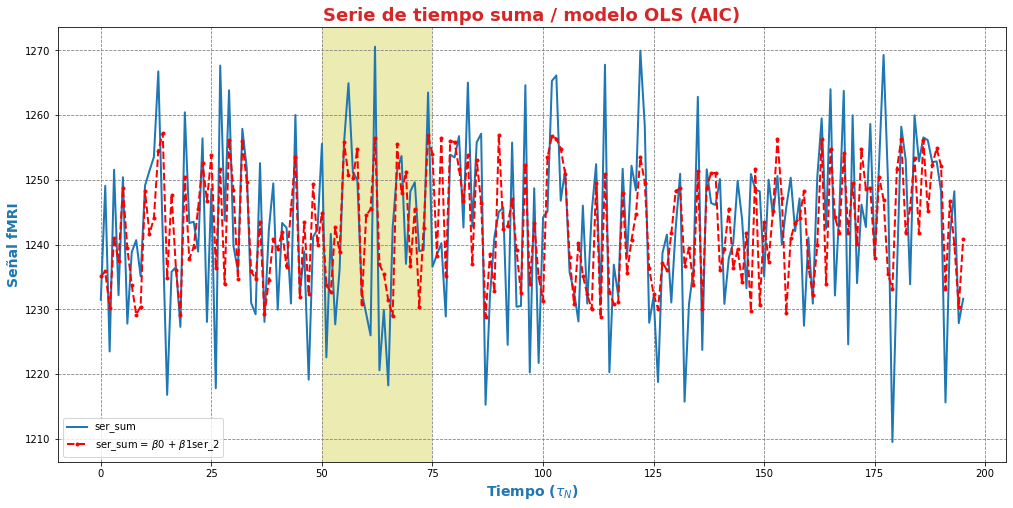

In [40]:
plot_series_osl(df_depen=df_suma, 
                models_osl=aic_all, 
                best=1, 
                titulo='Serie de tiempo suma / modelo OLS (AIC)', 
                name_save='serie_suma_model_ols_aic.png')

#### Graficamos la serie suma y el resultado del tercer mejor modelo mediante modelo de regresión OSL

                            OLS Regression Results                            
Dep. Variable:                ser_sum   R-squared:                       0.286
Model:                            OLS   Adj. R-squared:                  0.282
Method:                 Least Squares   F-statistic:                     77.59
Date:                Tue, 05 Jul 2022   Prob (F-statistic):           7.10e-16
Time:                        01:03:49   Log-Likelihood:                -746.71
No. Observations:                 196   AIC:                             1497.
Df Residuals:                     194   BIC:                             1504.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        749.2206     56.030     13.372      0.0

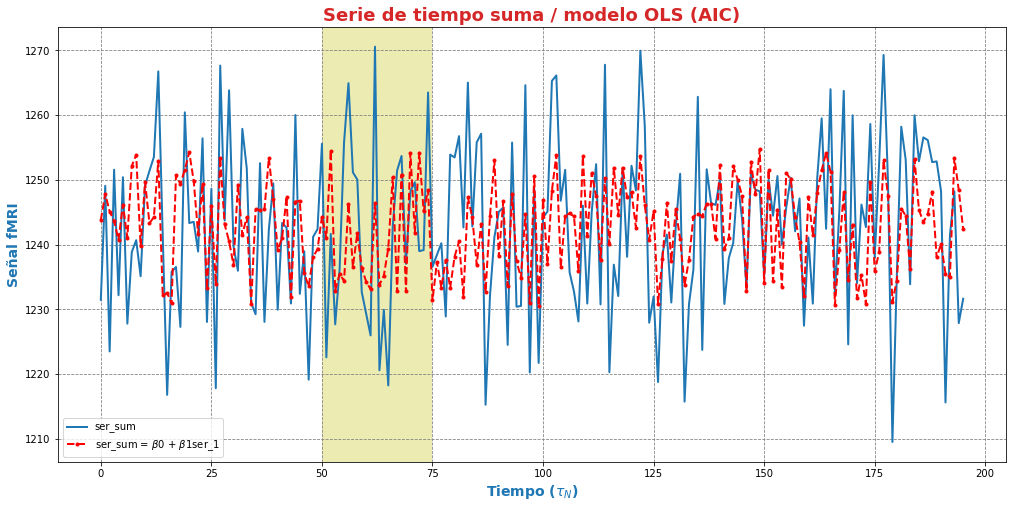

In [41]:
plot_series_osl(df_depen=df_suma, 
                models_osl=aic_all, 
                best=2, 
                titulo='Serie de tiempo suma / modelo OLS (AIC)', 
                name_save='serie_suma_model_ols_aic.png')

### Dataframe de comparacion de los modelos segun los estadisticos AIC, R2 Y R2 ajustado

In [42]:
compara_models_estad(aic=aic_all,
                     r2=r2_all,
                     r2_ajus=r2_ajus_all)

## Validación 2 / Regresión Lineal de series aleatorias


Usaremos el módulo statsmodels de Python para implementar el método Ordinary Least Squares( OLS ) de regresión lineal. Para la primera Validación, usaremos la data de *df_suma_random*, sin agregar series aleatorias adicionales.

Ahora vamos a 'contaminar' nuestros datos, agregando dos series aletorias que no son parte de la serie suma pero si seran parte de los modelos. La serie contaminante 1 (*ser_cont_1*) se encontrara por encima de la *ser1* y a una distancia entre las medias de 50% x mean[mask_csf]; La serie contaminante 2 (*ser_cont_2*) se encontrara por debajo de la *ser2* y a una distancia entre las medias de 50% x mean[mask_gm]; 

### Generamos series aleatorias contaminantes 1 y 2

In [43]:
np.random.seed(200)

# Creamos una serie por encima de ser 1
dif_1 = df_mean['mean']['ser_mask_csf']*0.5
mean_ser_cont_1 = df_mean['mean']['ser_mask_csf']+dif_1

ser_cont_1 = np.random.uniform(low= mean_ser_cont_1 - 15, 
                               high=mean_ser_cont_1 + 15, 
                               size=df_series_brain['ser_mask_csf'].shape[0]).tolist()

#Creamos una serie por por debajo de ser2 pero arriba de error
dif_2 = df_mean['mean']['ser_mask_wm']*0.5
mean_ser_cont_2 = df_mean['mean']['ser_mask_wm']-dif_2

ser_cont_2 = np.random.uniform(low= mean_ser_cont_2 - 15, 
                               high=mean_ser_cont_2 + 15, 
                               size=df_series_brain['ser_mask_csf'].shape[0]).tolist()

In [44]:
'''
Creamos DF de las series aleatorias contaminantes
'''
df_sr_con_1 = pd.DataFrame(ser_cont_1, columns=['ser_cont_1'])
df_sr_con_2 = pd.DataFrame(ser_cont_2, columns=['ser_cont_2'])

'''
Unimos DFs en una sola
'''
df_sr_conta = pd.merge(df_sr_con_1, df_sr_con_2, right_index=True, left_index=True)
df_sr_conta.round(3)

ser_cont_1  ser_cont_2
0       925.668     271.299
1       904.035     267.939
2       915.072     266.835
3       910.088     287.142
4       920.163     265.424
..          ...         ...
191     899.245     276.771
192     897.854     262.901
193     922.537     269.128
194     924.806     264.257
195     898.941     286.742

[196 rows x 2 columns]

### Unimos series contaminantes con el dataframe de las series de prueba

In [45]:
df_valida_2 = pd.merge(df_suma_random, df_sr_conta, right_index=True, left_index=True)
df_valida_2.round(3)

ser_sum    ser_1    ser_2   error  ser_cont_1  ser_cont_2
0    1231.461  609.464  536.822  85.174     925.668     271.299
1    1249.067  614.456  537.631  96.981     904.035     267.939
2    1223.490  611.083  531.741  80.666     915.072     266.835
3    1251.559  609.346  543.032  99.180     910.088     287.142
4    1232.171  605.710  539.354  87.107     920.163     265.424
..        ...      ...      ...     ...         ...         ...
191  1215.607  599.295  534.782  81.530     899.245     276.771
192  1241.382  598.586  548.867  93.929     897.854     262.901
193  1248.232  621.331  541.953  84.948     922.537     269.128
194  1227.860  615.187  531.881  80.792     924.806     264.257
195  1231.634  607.714  542.721  81.199     898.941     286.742

[196 rows x 6 columns]

#### Damos un formato a las DF solo para ser extraidas a un documento

In [46]:
df_2 = df_valida_2.copy()

new_index = df_2.index+1

nomb_colum = df_2.columns.values

header = pd.MultiIndex.from_product([['Series de tiempo: '], nomb_colum],
                                    names=[' ','tiempo ($\\tau_N$)'])
df_2 = pd.DataFrame(df_2.values, columns=header, index=new_index)

display(df_2.round(3))

Series de tiempo:                                        \
tiempo ($\tau_N$)            ser_sum    ser_1    ser_2   error ser_cont_1   
1                           1231.461  609.464  536.822  85.174    925.668   
2                           1249.067  614.456  537.631  96.981    904.035   
3                           1223.490  611.083  531.741  80.666    915.072   
4                           1251.559  609.346  543.032  99.180    910.088   
5                           1232.171  605.710  539.354  87.107    920.163   
..                               ...      ...      ...     ...        ...   
192                         1215.607  599.295  534.782  81.530    899.245   
193                         1241.382  598.586  548.867  93.929    897.854   
194                         1248.232  621.331  541.953  84.948    922.537   
195                         1227.860  615.187  531.881  80.792    924.806   
196                         1231.634  607.714  542.721  81.199    898.941   

                              
tiempo ($\tau_N$) ser_cont_2  
1                    271.299  
2                    267.939  
3                    266.835  
4                    287.142  
5                    265.424  
..                       ...  
192                  276.771  
193                  262.901  
194                  269.128  
195                  264.257  
196                  286.742  

[196 rows x 6 columns]

### Graficamos las series

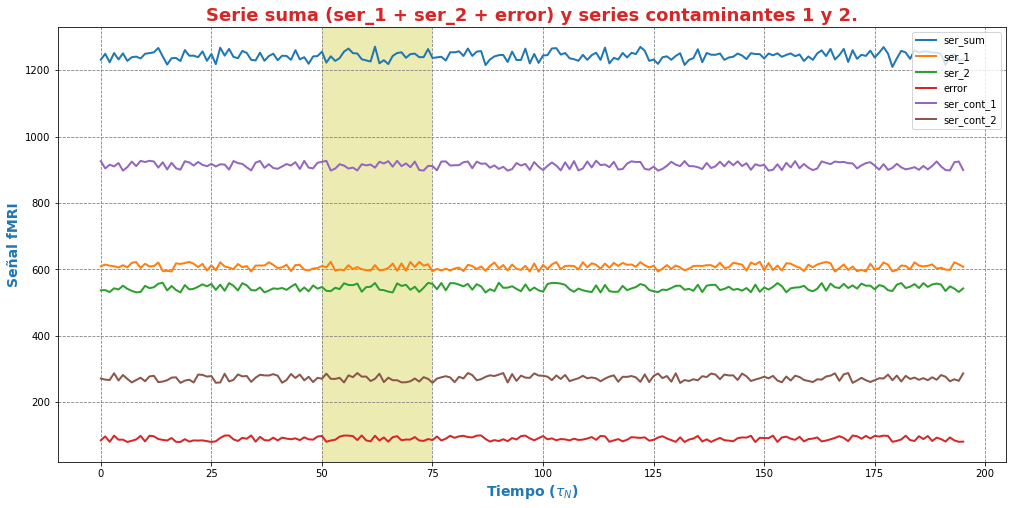

In [47]:
plot_series_time(df_data=df_valida_2, 
                 resaltar=['all'], 
                 titulo='Serie suma (ser_1 + ser_2 + error) y series contaminantes 1 y 2.', 
                 name_save='serie_suma_serie_conta?valida_2.png')

### Extraemos las combinaciones

Para extraer las posibles combinaciones o modelos que me pueden predecir la seria suma (*ser_sum*), en esta primera validación (asi como en las posteriores) no tomamos en cuenta en el modelo la serie error (*error*).

#### Lista de series que forman parte de las combinaciones ó modelos

Para extraer la lista que formaran parte de las combionaciones ó modelos, usamos la funcion *lista_dataframe*. Ahora, debemos tener claro que dataframe usaremos como input, para asi poder definir el input de la función *eliminar*. Por ejemplo, si usamos el dataframe *df_ser_random* y no queremos que la serie error sea parte del modelo, el input *eliminar* debe ser la lista *eliminar=['error']*; si usamos el dataframe *df_suma_random* y no queremos que la serie error sea parte del modelo, asi como la *ser_sum* ya que es la que queremos predecir, el input *eliminar* debe ser la lista *eliminar=['ser_sum', 'error']*

In [48]:
'''
Aplicamos funcion lista_dataframe
'''
list_ser = lista_dataframe(df=df_valida_2,
                           eliminar=['ser_sum','error'])

list_ser

['ser_1', 'ser_2', 'ser_cont_1', 'ser_cont_2']

#### Combinaciones de las series para generar ser_tiem_sum

In [49]:
'''
Posibles combinaciones de las series para generar ser_tiem_sum
'''
#ejecutamos funcion potencia
combi = potencia(list_ser)
combi

[[],
 ['ser_1'],
 ['ser_2'],
 ['ser_1', 'ser_2'],
 ['ser_cont_1'],
 ['ser_1', 'ser_cont_1'],
 ['ser_2', 'ser_cont_1'],
 ['ser_1', 'ser_2', 'ser_cont_1'],
 ['ser_cont_2'],
 ['ser_1', 'ser_cont_2'],
 ['ser_2', 'ser_cont_2'],
 ['ser_1', 'ser_2', 'ser_cont_2'],
 ['ser_cont_1', 'ser_cont_2'],
 ['ser_1', 'ser_cont_1', 'ser_cont_2'],
 ['ser_2', 'ser_cont_1', 'ser_cont_2'],
 ['ser_1', 'ser_2', 'ser_cont_1', 'ser_cont_2']]

Como al ejecutar la función potencia, entre los subconjuntos esta el conjunto vacio, lo eliminamos de nuestra lista

In [50]:
'''
Eliminamos primer elemento lista combi
'''
combi.pop(0)

print('posibles combinaciones de las series brain:\n', combi, '\n\n')

print('cantidad de combinaciones/modelos:\n\n', len(combi))

posibles combinaciones de las series brain:
 [['ser_1'], ['ser_2'], ['ser_1', 'ser_2'], ['ser_cont_1'], ['ser_1', 'ser_cont_1'], ['ser_2', 'ser_cont_1'], ['ser_1', 'ser_2', 'ser_cont_1'], ['ser_cont_2'], ['ser_1', 'ser_cont_2'], ['ser_2', 'ser_cont_2'], ['ser_1', 'ser_2', 'ser_cont_2'], ['ser_cont_1', 'ser_cont_2'], ['ser_1', 'ser_cont_1', 'ser_cont_2'], ['ser_2', 'ser_cont_1', 'ser_cont_2'], ['ser_1', 'ser_2', 'ser_cont_1', 'ser_cont_2']] 


cantidad de combinaciones/modelos:

 15


#### Generamos un DF de las combinaciones/modelos para un documento

In [51]:
pd.set_option( 'max_colwidth', 1)
crear_df_combi(lista_combi=combi, 
               columnas = 3)

Combinaciones / Modelos  \
   $\beta$0 + $\beta$1 ser_1                                                                
   $\beta$0 + $\beta$1 ser_1 + $\beta$2 ser_2 + $\beta$3 ser_cont_1 + $\beta$4 ser_cont_2   
   $\beta$0 + $\beta$1 ser_1 + $\beta$2 ser_cont_1 + $\beta$3 ser_cont_2                    
   $\beta$0 + $\beta$1 ser_2 + $\beta$2 ser_cont_1                                          
   $\beta$0 + $\beta$1 ser_cont_1                                                           

                                                 Combinaciones / Modelos  \
   $\beta$0 + $\beta$1 ser_1 + $\beta$2 ser_2                              
   $\beta$0 + $\beta$1 ser_1 + $\beta$2 ser_2 + $\beta$3 ser_cont_2        
   $\beta$0 + $\beta$1 ser_1 + $\beta$2 ser_cont_2                         
   $\beta$0 + $\beta$1 ser_2 + $\beta$2 ser_cont_1 + $\beta$3 ser_cont_2   
   $\beta$0 + $\beta$1 ser_cont_1 + $\beta$2 ser_cont_2                    

                                            Combinaciones / Modelos  
   $\beta$0 + $\beta$1 ser_1 + $\beta$2 ser_2 + $\beta$3 ser_cont_1  
   $\beta$0 + $\beta$1 ser_1 + $\beta$2 ser_cont_1                   
   $\beta$0 + $\beta$1 ser_2                                         
   $\beta$0 + $\beta$1 ser_2 + $\beta$2 ser_cont_2                   
   $\beta$0 + $\beta$1 ser_cont_2

### Aplicamos el modelo OLS

In [52]:
'''
Creamos DF con las series independientes
'''
df_ser_indep = df_valida_2.drop(['ser_sum','error'], axis=1)
df_ser_indep

ser_1       ser_2  ser_cont_1  ser_cont_2
0    609.464405  536.822439  925.668027  271.298954
1    614.455681  537.630694  904.035482  267.939318
2    611.082901  531.740875  915.071664  266.834516
3    609.346495  543.032499  910.088320  287.142214
4    605.709644  539.353876  920.163280  265.424289
..          ...         ...         ...         ...
191  599.295312  534.782434  899.245218  276.771131
192  598.585790  548.866953  897.854431  262.901252
193  621.331172  541.953028  922.537340  269.127536
194  615.186524  531.881389  924.805534  264.257052
195  607.713764  542.720968  898.941225  286.741797

[196 rows x 4 columns]

#### Ejecutamos la función  *best_osl*  para determinar el mejor modelo mediante modelo de regresión OSL

In [53]:
modelo_regre = best_osl(df_depen=df_suma, 
                        df_indep=df_ser_indep, 
                        var_depen='ser_sum',
                        lista_combi=combi)

In [54]:
mejor_aic = modelo_regre[0]
aic_all = modelo_regre[1]
mejor_r2 = modelo_regre[2]
r2_all = modelo_regre[3]
mejor_r2_ajus = modelo_regre[4]
r2_ajus_all = modelo_regre[5]

In [55]:
mejor_aic

serie       MODELO      AIC  \
0  0      ser_1,ser_2  1263.62   

                                                                       resultado_regresión  
0  <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f60da39f310>

In [56]:
pd.set_option('display.max_colwidth', 60)
aic_all

serie                             MODELO      AIC  \
0       0                        ser_1,ser_2  1263.62   
1       0             ser_1,ser_2,ser_cont_2  1265.02   
2       0             ser_1,ser_2,ser_cont_1  1265.48   
3       0  ser_1,ser_2,ser_cont_1,ser_cont_2  1266.89   
4       0                              ser_2  1453.79   
5       0                   ser_2,ser_cont_1  1455.72   
6       0                   ser_2,ser_cont_2  1455.79   
7       0        ser_2,ser_cont_1,ser_cont_2  1457.72   
8       0                              ser_1  1497.42   
9       0                   ser_1,ser_cont_1  1497.46   
10      0        ser_1,ser_cont_1,ser_cont_2  1498.69   
11      0                   ser_1,ser_cont_2  1498.70   
12      0                         ser_cont_1  1561.34   
13      0              ser_cont_1,ser_cont_2  1563.20   
14      0                         ser_cont_2  1563.24   

                                            resultado_regresión  
0   <statsmodels.regression.linear_model.RegressionResultsWr...  
1   <statsmodels.regression.linear_model.RegressionResultsWr...  
2   <statsmodels.regression.linear_model.RegressionResultsWr...  
3   <statsmodels.regression.linear_model.RegressionResultsWr...  
4   <statsmodels.regression.linear_model.RegressionResultsWr...  
5   <statsmodels.regression.linear_model.RegressionResultsWr...  
6   <statsmodels.regression.linear_model.RegressionResultsWr...  
7   <statsmodels.regression.linear_model.RegressionResultsWr...  
8   <statsmodels.regression.linear_model.RegressionResultsWr...  
9   <statsmodels.regression.linear_model.RegressionResultsWr...  
10  <statsmodels.regression.linear_model.RegressionResultsWr...  
11  <statsmodels.regression.linear_model.RegressionResultsWr...  
12  <statsmodels.regression.linear_model.RegressionResultsWr...  
13  <statsmodels.regression.linear_model.RegressionResultsWr...  
14  <statsmodels.regression.linear_model.RegressionResultsWr...

#### Aplicamos función *analisi_p* para extraer los valores p de los regresores, y confirmar mejor modelo

In [57]:
analisi_p(df_anali=mejor_aic, 
          nivel_signif=0.05)

serie       MODELO      AIC  const  ser_1  ser_2 valores_p_regresores  \
0      0  ser_1,ser_2  1263.62   0.01    0.0    0.0     [0.01, 0.0, 0.0]   

   suma_evaluación     MODELO_P  
0                0  ser_1,ser_2

#### Graficamos la serie suma y el resultado del mejor modelo mediante modelo de regresión OSL

                            OLS Regression Results                            
Dep. Variable:                ser_sum   R-squared:                       0.786
Model:                            OLS   Adj. R-squared:                  0.783
Method:                 Least Squares   F-statistic:                     353.4
Date:                Tue, 05 Jul 2022   Prob (F-statistic):           3.03e-65
Time:                        01:03:51   Log-Likelihood:                -628.81
No. Observations:                 196   AIC:                             1264.
Df Residuals:                     193   BIC:                             1273.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        116.3428     42.874      2.714      0.0

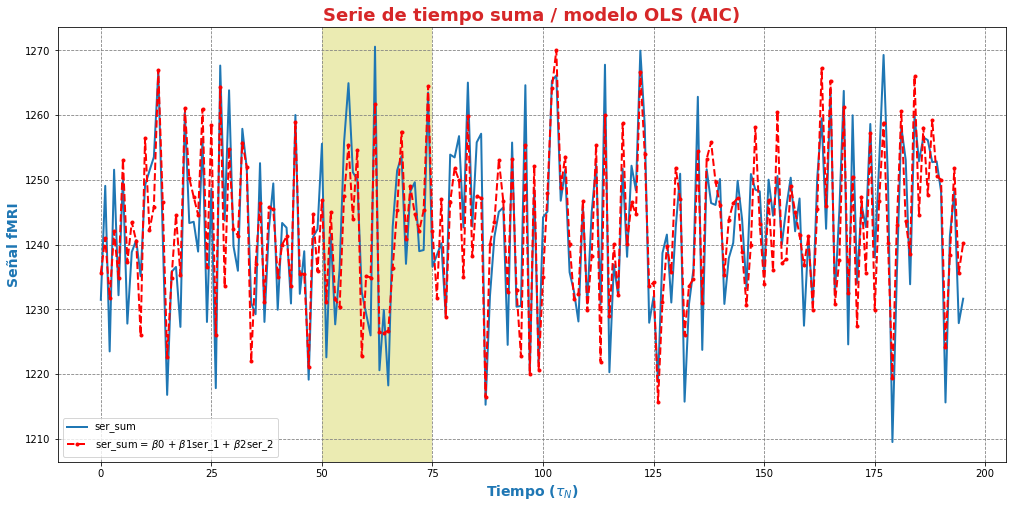

In [58]:
plot_series_osl(df_depen=df_suma, 
                models_osl=aic_all, 
                best=0, 
                titulo='Serie de tiempo suma / modelo OLS (AIC)', 
                name_save='serie_suma_model_ols_aic.png')

#### Graficamos la serie suma y el resultado del modelo que menos se ajusta mediante modelo de regresión OSL

                            OLS Regression Results                            
Dep. Variable:                ser_sum   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                    0.1218
Date:                Tue, 05 Jul 2022   Prob (F-statistic):              0.727
Time:                        01:03:52   Log-Likelihood:                -779.62
No. Observations:                 196   AIC:                             1563.
Df Residuals:                     194   BIC:                             1570.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1253.3361     30.427     41.191      0.0

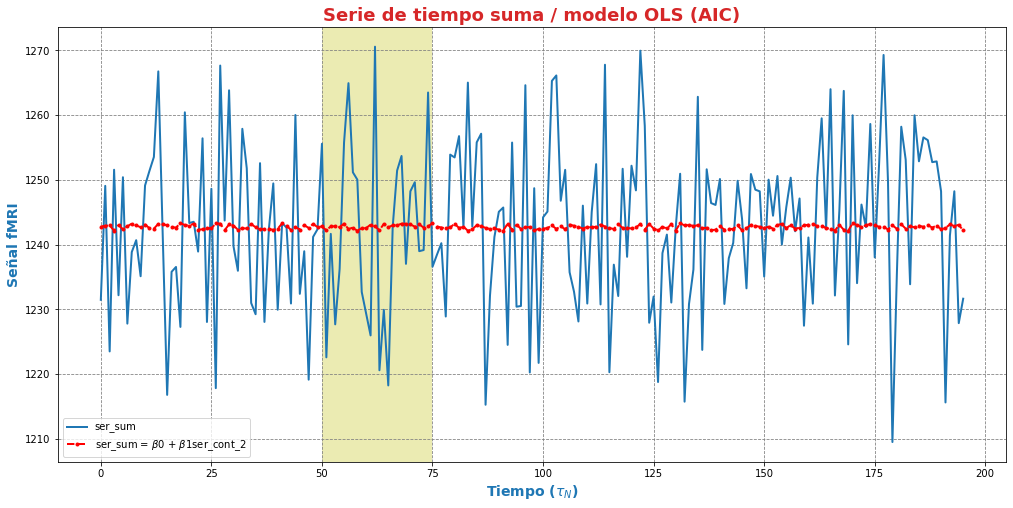

In [59]:
plot_series_osl(df_depen=df_suma, 
                models_osl=aic_all, 
                best=14, 
                titulo='Serie de tiempo suma / modelo OLS (AIC)', 
                name_save='serie_suma_model_ols_aic.png')

### Dataframe de comparacion de los modelos segun los estadisticos AIC, R2 Y R2 ajustado

In [60]:
compara_models_estad(aic=aic_all,
                     r2=r2_all,
                     r2_ajus=r2_ajus_all)

## Validación 3 / Regresión Lineal de series aleatorias


Usaremos el módulo statsmodels de Python para implementar el método Ordinary Least Squares( OLS ) de regresión lineal. Para la primera Validación, usaremos la data de *df_suma_random*, sin agregar series aleatorias adicionales.

Ahora vamos a 'contaminar' nuestros datos, agregando dos series aletorias que no son parte de la serie suma pero si seran parte de los modelos. La serie contaminante 5 (*ser_cont_5*) se encontrara se encontrara por encima de la *ser1* y a una distancia entre las medias de 50% x mean[mask_csf]; mientras que la serie contaminante 6 (*ser_cont_6*) se encontrara cerca y por debajo de *ser2* y a una distancia entre las medias de 5% x mean[mask_gm].

### Generamos series aleatorias contaminantes 3 y 4

In [61]:
np.random.seed(300)

# Creamos una serie por encima de ser 1

dif_3 = df_mean['mean']['ser_mask_csf']*0.5
mean_ser_cont_3 = df_mean['mean']['ser_mask_csf']+dif_3

ser_cont_3 = np.random.uniform(low= mean_ser_cont_3 - 15, 
                               high=mean_ser_cont_3 + 15, 
                               size=df_series_brain['ser_mask_csf'].shape[0]).tolist()

#Creamos una serie por por debajo de ser2 pero arriba de error
dif_4 = df_mean['mean']['ser_mask_wm']*0.05
mean_ser_cont_4 = df_mean['mean']['ser_mask_wm']-dif_4

ser_cont_4 = np.random.uniform(low= mean_ser_cont_4 - 15, 
                               high=mean_ser_cont_4 + 15, 
                               size=df_series_brain['ser_mask_csf'].shape[0]).tolist()

In [62]:
'''
Creamos DF de las series aleatorias contaminantes
'''
df_sr_con_3 = pd.DataFrame(ser_cont_3, columns=['ser_cont_3'])
df_sr_con_4 = pd.DataFrame(ser_cont_4, columns=['ser_cont_4'])

'''
Unimos DFs en una sola
'''
df_sr_conta_2 = pd.merge(df_sr_con_3, df_sr_con_4, right_index=True, left_index=True)
df_sr_conta_2.round(3)

ser_cont_3  ser_cont_4
0       910.773     515.723
1       903.870     507.357
2       908.311     513.249
3       905.962     511.614
4       904.471     508.338
..          ...         ...
191     897.408     506.311
192     902.127     504.959
193     912.111     506.937
194     917.594     523.118
195     910.832     522.335

[196 rows x 2 columns]

### Unimos series contaminantes con el dataframe de las series de prueba

In [63]:
df_valida_3 = pd.merge(df_suma_random, df_sr_conta_2, right_index=True, left_index=True)
df_valida_3.round(3)

ser_sum    ser_1    ser_2   error  ser_cont_3  ser_cont_4
0    1231.461  609.464  536.822  85.174     910.773     515.723
1    1249.067  614.456  537.631  96.981     903.870     507.357
2    1223.490  611.083  531.741  80.666     908.311     513.249
3    1251.559  609.346  543.032  99.180     905.962     511.614
4    1232.171  605.710  539.354  87.107     904.471     508.338
..        ...      ...      ...     ...         ...         ...
191  1215.607  599.295  534.782  81.530     897.408     506.311
192  1241.382  598.586  548.867  93.929     902.127     504.959
193  1248.232  621.331  541.953  84.948     912.111     506.937
194  1227.860  615.187  531.881  80.792     917.594     523.118
195  1231.634  607.714  542.721  81.199     910.832     522.335

[196 rows x 6 columns]

#### Damos un formato a las DF solo para ser extraidas a un documento

In [64]:
df_3 = df_valida_3.copy()

new_index = df_3.index+1

nomb_colum = df_3.columns.values

header = pd.MultiIndex.from_product([['Series de tiempo: '], nomb_colum],
                                    names=[' ','tiempo ($\\tau_N$)'])
df_3 = pd.DataFrame(df_3.values, columns=header, index = new_index)

display(df_3.round(3))

Series de tiempo:                                        \
tiempo ($\tau_N$)            ser_sum    ser_1    ser_2   error ser_cont_3   
1                           1231.461  609.464  536.822  85.174    910.773   
2                           1249.067  614.456  537.631  96.981    903.870   
3                           1223.490  611.083  531.741  80.666    908.311   
4                           1251.559  609.346  543.032  99.180    905.962   
5                           1232.171  605.710  539.354  87.107    904.471   
..                               ...      ...      ...     ...        ...   
192                         1215.607  599.295  534.782  81.530    897.408   
193                         1241.382  598.586  548.867  93.929    902.127   
194                         1248.232  621.331  541.953  84.948    912.111   
195                         1227.860  615.187  531.881  80.792    917.594   
196                         1231.634  607.714  542.721  81.199    910.832   

                              
tiempo ($\tau_N$) ser_cont_4  
1                    515.723  
2                    507.357  
3                    513.249  
4                    511.614  
5                    508.338  
..                       ...  
192                  506.311  
193                  504.959  
194                  506.937  
195                  523.118  
196                  522.335  

[196 rows x 6 columns]

### Graficamos las series

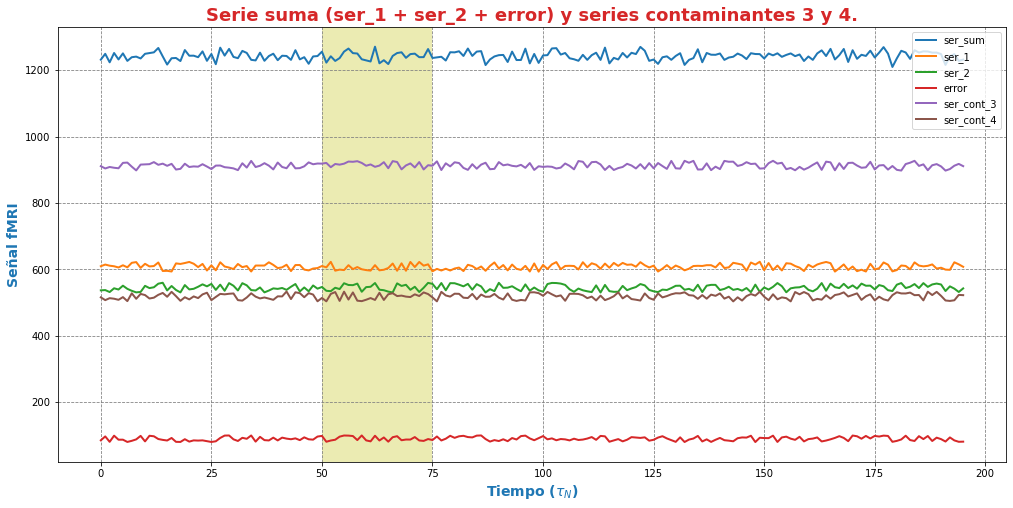

In [65]:
plot_series_time(df_data=df_valida_3, 
                 resaltar=['all'], 
                 titulo='Serie suma (ser_1 + ser_2 + error) y series contaminantes 3 y 4.', 
                 name_save='serie_suma_serie_conta?valida_2.png')

### Extraemos las combinaciones

Para extraer las posibles combinaciones o modelos que me pueden predecir la seria suma (*ser_sum*), en esta primera validación (asi como en las posteriores) no tomamos en cuenta en el modelo la serie error (*error*).

#### Lista de series que forman parte de las combinaciones ó modelos

Para extraer la lista que formaran parte de las combionaciones ó modelos, usamos la funcion *lista_dataframe*. Ahora, debemos tener claro que dataframe usaremos como input, para asi poder definir el input de la función *eliminar*. Por ejemplo, si usamos el dataframe *df_ser_random* y no queremos que la serie error sea parte del modelo, el input *eliminar* debe ser la lista *eliminar=['error']*; si usamos el dataframe *df_suma_random* y no queremos que la serie error sea parte del modelo, asi como la *ser_sum* ya que es la que queremos predecir, el input *eliminar* debe ser la lista *eliminar=['ser_sum', 'error']*

In [66]:
'''
Aplicamos funcion lista_dataframe
'''
list_ser = lista_dataframe(df=df_valida_3,
                           eliminar=['ser_sum','error'])

list_ser

['ser_1', 'ser_2', 'ser_cont_3', 'ser_cont_4']

#### Combinaciones de las series para generar ser_tiem_sum

In [67]:
'''
Posibles combinaciones de las series para generar ser_tiem_sum
'''
#ejecutamos funcion potencia
combi = potencia(list_ser)
combi

[[],
 ['ser_1'],
 ['ser_2'],
 ['ser_1', 'ser_2'],
 ['ser_cont_3'],
 ['ser_1', 'ser_cont_3'],
 ['ser_2', 'ser_cont_3'],
 ['ser_1', 'ser_2', 'ser_cont_3'],
 ['ser_cont_4'],
 ['ser_1', 'ser_cont_4'],
 ['ser_2', 'ser_cont_4'],
 ['ser_1', 'ser_2', 'ser_cont_4'],
 ['ser_cont_3', 'ser_cont_4'],
 ['ser_1', 'ser_cont_3', 'ser_cont_4'],
 ['ser_2', 'ser_cont_3', 'ser_cont_4'],
 ['ser_1', 'ser_2', 'ser_cont_3', 'ser_cont_4']]

Como al ejecutar la función potencia, entre los subconjuntos esta el conjunto vacio, lo eliminamos de nuestra lista

In [68]:
'''
Eliminamos primer elemento lista combi
'''
combi.pop(0)

print('posibles combinaciones de las series brain:\n', combi, '\n\n')

print('cantidad de combinaciones/modelos:\n\n', len(combi))

posibles combinaciones de las series brain:
 [['ser_1'], ['ser_2'], ['ser_1', 'ser_2'], ['ser_cont_3'], ['ser_1', 'ser_cont_3'], ['ser_2', 'ser_cont_3'], ['ser_1', 'ser_2', 'ser_cont_3'], ['ser_cont_4'], ['ser_1', 'ser_cont_4'], ['ser_2', 'ser_cont_4'], ['ser_1', 'ser_2', 'ser_cont_4'], ['ser_cont_3', 'ser_cont_4'], ['ser_1', 'ser_cont_3', 'ser_cont_4'], ['ser_2', 'ser_cont_3', 'ser_cont_4'], ['ser_1', 'ser_2', 'ser_cont_3', 'ser_cont_4']] 


cantidad de combinaciones/modelos:

 15


#### Generamos un DF de las combinaciones/modelos para un documento

In [69]:
pd.set_option( 'max_colwidth', 1)
crear_df_combi(lista_combi=combi, 
               columnas = 3)

Combinaciones / Modelos  \
   $\beta$0 + $\beta$1 ser_1                                                                
   $\beta$0 + $\beta$1 ser_1 + $\beta$2 ser_2 + $\beta$3 ser_cont_3 + $\beta$4 ser_cont_4   
   $\beta$0 + $\beta$1 ser_1 + $\beta$2 ser_cont_3 + $\beta$3 ser_cont_4                    
   $\beta$0 + $\beta$1 ser_2 + $\beta$2 ser_cont_3                                          
   $\beta$0 + $\beta$1 ser_cont_3                                                           

                                                 Combinaciones / Modelos  \
   $\beta$0 + $\beta$1 ser_1 + $\beta$2 ser_2                              
   $\beta$0 + $\beta$1 ser_1 + $\beta$2 ser_2 + $\beta$3 ser_cont_4        
   $\beta$0 + $\beta$1 ser_1 + $\beta$2 ser_cont_4                         
   $\beta$0 + $\beta$1 ser_2 + $\beta$2 ser_cont_3 + $\beta$3 ser_cont_4   
   $\beta$0 + $\beta$1 ser_cont_3 + $\beta$2 ser_cont_4                    

                                            Combinaciones / Modelos  
   $\beta$0 + $\beta$1 ser_1 + $\beta$2 ser_2 + $\beta$3 ser_cont_3  
   $\beta$0 + $\beta$1 ser_1 + $\beta$2 ser_cont_3                   
   $\beta$0 + $\beta$1 ser_2                                         
   $\beta$0 + $\beta$1 ser_2 + $\beta$2 ser_cont_4                   
   $\beta$0 + $\beta$1 ser_cont_4

### Aplicamos el modelo OLS

In [70]:
'''
Creamos DF con las series independientes
'''
df_ser_indep = df_valida_3.drop(['ser_sum','error'], axis=1)
df_ser_indep

ser_1       ser_2  ser_cont_3  ser_cont_4
0    609.464405  536.822439  910.772736  515.723270
1    614.455681  537.630694  903.869729  507.356907
2    611.082901  531.740875  908.311497  513.249412
3    609.346495  543.032499  905.962330  511.613755
4    605.709644  539.353876  904.471397  508.337658
..          ...         ...         ...         ...
191  599.295312  534.782434  897.407648  506.311234
192  598.585790  548.866953  902.127398  504.959196
193  621.331172  541.953028  912.110507  506.937433
194  615.186524  531.881389  917.594428  523.117773
195  607.713764  542.720968  910.832025  522.334792

[196 rows x 4 columns]

#### Ejecutamos la función  *best_osl*  para determinar el mejor modelo mediante modelo de regresión OSL

In [71]:
modelo_regre = best_osl(df_depen=df_suma, 
                        df_indep=df_ser_indep, 
                        var_depen='ser_sum',
                        lista_combi=combi)

In [72]:
mejor_aic = modelo_regre[0]
aic_all = modelo_regre[1]
mejor_r2 = modelo_regre[2]
r2_all = modelo_regre[3]
mejor_r2_ajus = modelo_regre[4]
r2_ajus_all = modelo_regre[5]

In [73]:
mejor_aic

serie       MODELO      AIC  \
0  0      ser_1,ser_2  1263.62   

                                                                       resultado_regresión  
0  <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f60da9bff10>

In [74]:
pd.set_option('display.max_colwidth', 60)
aic_all

serie                             MODELO      AIC  \
0       0                        ser_1,ser_2  1263.62   
1       0             ser_1,ser_2,ser_cont_4  1264.84   
2       0             ser_1,ser_2,ser_cont_3  1265.17   
3       0  ser_1,ser_2,ser_cont_3,ser_cont_4  1266.46   
4       0        ser_2,ser_cont_3,ser_cont_4  1450.73   
5       0                   ser_2,ser_cont_4  1451.12   
6       0                   ser_2,ser_cont_3  1453.73   
7       0                              ser_2  1453.79   
8       0                              ser_1  1497.42   
9       0                   ser_1,ser_cont_4  1499.41   
10      0                   ser_1,ser_cont_3  1499.42   
11      0        ser_1,ser_cont_3,ser_cont_4  1501.41   
12      0                         ser_cont_3  1561.81   
13      0                         ser_cont_4  1561.93   
14      0              ser_cont_3,ser_cont_4  1562.24   

                                            resultado_regresión  
0   <statsmodels.regression.linear_model.RegressionResultsWr...  
1   <statsmodels.regression.linear_model.RegressionResultsWr...  
2   <statsmodels.regression.linear_model.RegressionResultsWr...  
3   <statsmodels.regression.linear_model.RegressionResultsWr...  
4   <statsmodels.regression.linear_model.RegressionResultsWr...  
5   <statsmodels.regression.linear_model.RegressionResultsWr...  
6   <statsmodels.regression.linear_model.RegressionResultsWr...  
7   <statsmodels.regression.linear_model.RegressionResultsWr...  
8   <statsmodels.regression.linear_model.RegressionResultsWr...  
9   <statsmodels.regression.linear_model.RegressionResultsWr...  
10  <statsmodels.regression.linear_model.RegressionResultsWr...  
11  <statsmodels.regression.linear_model.RegressionResultsWr...  
12  <statsmodels.regression.linear_model.RegressionResultsWr...  
13  <statsmodels.regression.linear_model.RegressionResultsWr...  
14  <statsmodels.regression.linear_model.RegressionResultsWr...

#### Aplicamos función *analisi_p* para extraer los valores p de los regresores, y confirmar mejor modelo

In [75]:
analisi_p(df_anali=mejor_aic, 
          nivel_signif=0.05)

serie       MODELO      AIC  const  ser_1  ser_2 valores_p_regresores  \
0      0  ser_1,ser_2  1263.62   0.01    0.0    0.0     [0.01, 0.0, 0.0]   

   suma_evaluación     MODELO_P  
0                0  ser_1,ser_2

#### Graficamos la serie suma y el resultado del mejor modelo mediante modelo de regresión OSL

                            OLS Regression Results                            
Dep. Variable:                ser_sum   R-squared:                       0.786
Model:                            OLS   Adj. R-squared:                  0.783
Method:                 Least Squares   F-statistic:                     353.4
Date:                Tue, 05 Jul 2022   Prob (F-statistic):           3.03e-65
Time:                        01:03:55   Log-Likelihood:                -628.81
No. Observations:                 196   AIC:                             1264.
Df Residuals:                     193   BIC:                             1273.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        116.3428     42.874      2.714      0.0

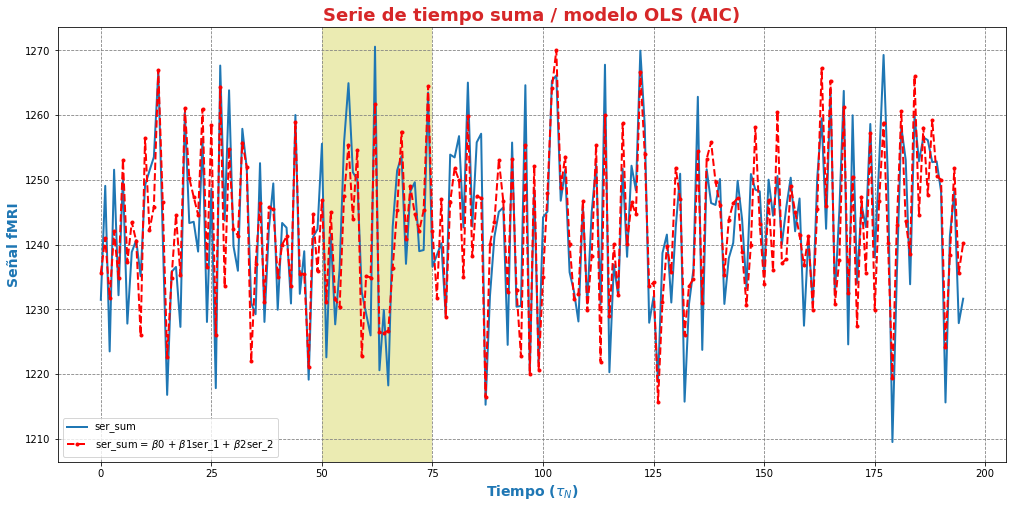

In [76]:
plot_series_osl(df_depen=df_suma, 
                models_osl=aic_all, 
                best=0, 
                titulo='Serie de tiempo suma / modelo OLS (AIC)', 
                name_save='serie_suma_model_ols_aic.png')

#### Graficamos la serie suma y el resultado del modelo que menos se ajusta mediante modelo de regresión OSL

                            OLS Regression Results                            
Dep. Variable:                ser_sum   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     1.551
Date:                Tue, 05 Jul 2022   Prob (F-statistic):              0.215
Time:                        01:03:55   Log-Likelihood:                -778.12
No. Observations:                 196   AIC:                             1562.
Df Residuals:                     193   BIC:                             1572.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1443.7009    117.792     12.256      0.0

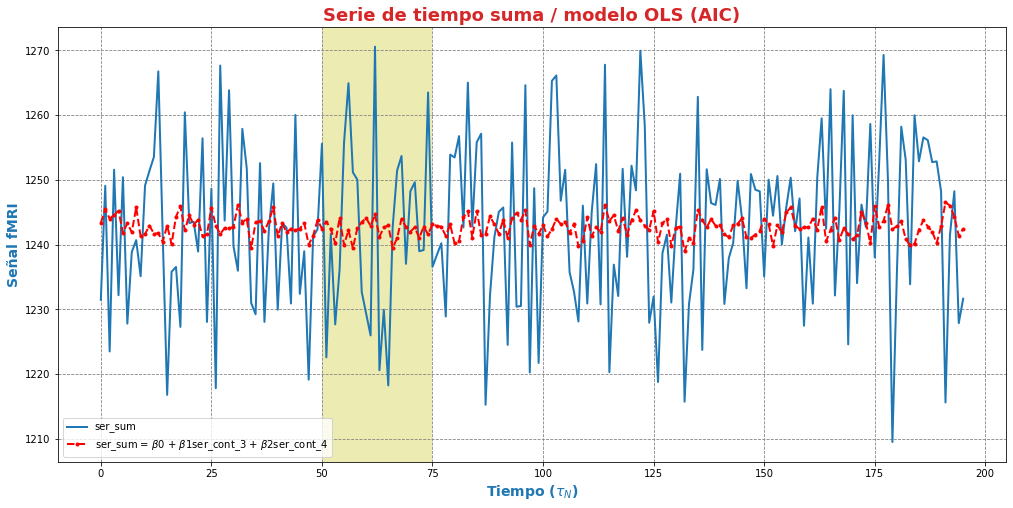

In [77]:
plot_series_osl(df_depen=df_suma, 
                models_osl=aic_all, 
                best=14, 
                titulo='Serie de tiempo suma / modelo OLS (AIC)', 
                name_save='serie_suma_model_ols_aic.png')

### Dataframe de comparacion de los modelos segun los estadisticos AIC, R2 Y R2 ajustado

In [78]:
compara_models_estad(aic=aic_all,
                     r2=r2_all,
                     r2_ajus=r2_ajus_all)

## Validación 4 / Regresión Lineal de series aleatorias


Usaremos el módulo statsmodels de Python para implementar el método Ordinary Least Squares( OLS ) de regresión lineal. Para la primera Validación, usaremos la data de *df_suma_random*, sin agregar series aleatorias adicionales.

Ahora vamos a 'contaminar' nuestros datos, agregando dos series aletorias que no son parte de la serie suma pero si seran parte de los modelos. La serie contaminante 5 (*ser_cont_5*) se encontrara se encontrara cerca y por encima de la *ser1* y a una distancia entre las medias de 5% x mean[mask_csf]; mientras que la serie contaminante 6 (*ser_cont_6*) se encontrara por debajo de *ser2* y a una distancia entre las medias de 50% x mean[mask_gm].

### Generamos series aleatorias contaminantes 5 y 6

In [79]:
np.random.seed(300)

# Creamos una serie por encima de ser 1

dif_5 = df_mean['mean']['ser_mask_csf']*0.05
mean_ser_cont_5 = df_mean['mean']['ser_mask_csf']+dif_5

ser_cont_5 = np.random.uniform(low= mean_ser_cont_5 - 15, 
                               high=mean_ser_cont_5 + 15, 
                               size=196).tolist()

#Creamos una serie por por debajo de ser2 pero arriba de error
dif_6 = df_mean['mean']['ser_mask_wm']*0.5
mean_ser_cont_6 = df_mean['mean']['ser_mask_wm']-dif_6

ser_cont_6 = np.random.uniform(low= mean_ser_cont_6 - 15, 
                               high=mean_ser_cont_6 + 15, 
                               size=196).tolist()

In [80]:
'''
Creamos DF de las series aleatorias contaminantes
'''
df_sr_con_5 = pd.DataFrame(ser_cont_5, columns=['ser_cont_5'])
df_sr_con_6 = pd.DataFrame(ser_cont_6, columns=['ser_cont_6'])

'''
Unimos DFs en una sola
'''
df_sr_conta_3 = pd.merge(df_sr_con_5, df_sr_con_6, right_index=True, left_index=True)
df_sr_conta_3.round(3)

ser_cont_5  ser_cont_6
0       637.101     270.094
1       630.198     261.727
2       634.640     267.620
3       632.291     265.984
4       630.800     262.708
..          ...         ...
191     623.736     260.682
192     628.456     259.330
193     638.439     261.308
194     643.923     277.488
195     637.160     276.705

[196 rows x 2 columns]

### Unimos series contaminantes con el dataframe de las series de prueba

In [81]:
df_valida_4 = pd.merge(df_suma_random, df_sr_conta_3, right_index=True, left_index=True)
df_valida_4.round(3)

ser_sum    ser_1    ser_2   error  ser_cont_5  ser_cont_6
0    1231.461  609.464  536.822  85.174     637.101     270.094
1    1249.067  614.456  537.631  96.981     630.198     261.727
2    1223.490  611.083  531.741  80.666     634.640     267.620
3    1251.559  609.346  543.032  99.180     632.291     265.984
4    1232.171  605.710  539.354  87.107     630.800     262.708
..        ...      ...      ...     ...         ...         ...
191  1215.607  599.295  534.782  81.530     623.736     260.682
192  1241.382  598.586  548.867  93.929     628.456     259.330
193  1248.232  621.331  541.953  84.948     638.439     261.308
194  1227.860  615.187  531.881  80.792     643.923     277.488
195  1231.634  607.714  542.721  81.199     637.160     276.705

[196 rows x 6 columns]

#### Damos un formato a las DF solo para ser extraidas a un documento

In [82]:
df_4 = df_valida_4.copy()

new_index = df_4.index+1

nomb_colum = df_4.columns.values

header = pd.MultiIndex.from_product([['Series de tiempo: '], nomb_colum],
                                    names=[' ','tiempo ($\\tau_N$)'])
df_4 = pd.DataFrame(df_4.values, columns=header, index = new_index)

display(df_4.round(3))

Series de tiempo:                                        \
tiempo ($\tau_N$)            ser_sum    ser_1    ser_2   error ser_cont_5   
1                           1231.461  609.464  536.822  85.174    637.101   
2                           1249.067  614.456  537.631  96.981    630.198   
3                           1223.490  611.083  531.741  80.666    634.640   
4                           1251.559  609.346  543.032  99.180    632.291   
5                           1232.171  605.710  539.354  87.107    630.800   
..                               ...      ...      ...     ...        ...   
192                         1215.607  599.295  534.782  81.530    623.736   
193                         1241.382  598.586  548.867  93.929    628.456   
194                         1248.232  621.331  541.953  84.948    638.439   
195                         1227.860  615.187  531.881  80.792    643.923   
196                         1231.634  607.714  542.721  81.199    637.160   

                              
tiempo ($\tau_N$) ser_cont_6  
1                    270.094  
2                    261.727  
3                    267.620  
4                    265.984  
5                    262.708  
..                       ...  
192                  260.682  
193                  259.330  
194                  261.308  
195                  277.488  
196                  276.705  

[196 rows x 6 columns]

### Graficamos las series

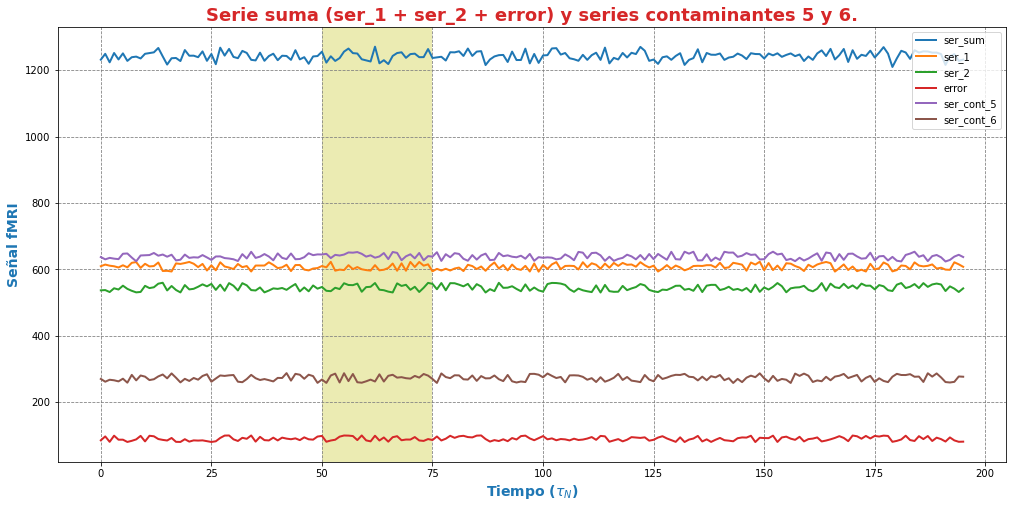

In [83]:
plot_series_time(df_data=df_valida_4, 
                 resaltar=['all'], 
                 titulo='Serie suma (ser_1 + ser_2 + error) y series contaminantes 5 y 6.', 
                 name_save='serie_suma_serie_conta?valida_2.png')

### Extraemos las combinaciones

Para extraer las posibles combinaciones o modelos que me pueden predecir la seria suma (*ser_sum*), en esta primera validación (asi como en las posteriores) no tomamos en cuenta en el modelo la serie error (*error*).

#### Lista de series que forman parte de las combinaciones ó modelos

Para extraer la lista que formaran parte de las combionaciones ó modelos, usamos la funcion *lista_dataframe*. Ahora, debemos tener claro que dataframe usaremos como input, para asi poder definir el input de la función *eliminar*. Por ejemplo, si usamos el dataframe *df_ser_random* y no queremos que la serie error sea parte del modelo, el input *eliminar* debe ser la lista *eliminar=['error']*; si usamos el dataframe *df_suma_random* y no queremos que la serie error sea parte del modelo, asi como la *ser_sum* ya que es la que queremos predecir, el input *eliminar* debe ser la lista *eliminar=['ser_sum', 'error']*

In [84]:
'''
Aplicamos funcion lista_dataframe
'''
list_ser = lista_dataframe(df=df_valida_4,
                           eliminar=['ser_sum','error'])

list_ser

['ser_1', 'ser_2', 'ser_cont_5', 'ser_cont_6']

#### Combinaciones de las series para generar ser_tiem_sum

In [85]:
'''
Posibles combinaciones de las series para generar ser_tiem_sum
'''
#ejecutamos funcion potencia
combi = potencia(list_ser)
combi

[[],
 ['ser_1'],
 ['ser_2'],
 ['ser_1', 'ser_2'],
 ['ser_cont_5'],
 ['ser_1', 'ser_cont_5'],
 ['ser_2', 'ser_cont_5'],
 ['ser_1', 'ser_2', 'ser_cont_5'],
 ['ser_cont_6'],
 ['ser_1', 'ser_cont_6'],
 ['ser_2', 'ser_cont_6'],
 ['ser_1', 'ser_2', 'ser_cont_6'],
 ['ser_cont_5', 'ser_cont_6'],
 ['ser_1', 'ser_cont_5', 'ser_cont_6'],
 ['ser_2', 'ser_cont_5', 'ser_cont_6'],
 ['ser_1', 'ser_2', 'ser_cont_5', 'ser_cont_6']]

Como al ejecutar la función potencia, entre los subconjuntos esta el conjunto vacio, lo eliminamos de nuestra lista

In [86]:
'''
Eliminamos primer elemento lista combi
'''
combi.pop(0)

print('posibles combinaciones de las series brain:\n', combi, '\n\n')

print('cantidad de combinaciones/modelos:\n\n', len(combi))

posibles combinaciones de las series brain:
 [['ser_1'], ['ser_2'], ['ser_1', 'ser_2'], ['ser_cont_5'], ['ser_1', 'ser_cont_5'], ['ser_2', 'ser_cont_5'], ['ser_1', 'ser_2', 'ser_cont_5'], ['ser_cont_6'], ['ser_1', 'ser_cont_6'], ['ser_2', 'ser_cont_6'], ['ser_1', 'ser_2', 'ser_cont_6'], ['ser_cont_5', 'ser_cont_6'], ['ser_1', 'ser_cont_5', 'ser_cont_6'], ['ser_2', 'ser_cont_5', 'ser_cont_6'], ['ser_1', 'ser_2', 'ser_cont_5', 'ser_cont_6']] 


cantidad de combinaciones/modelos:

 15


#### Generamos un DF de las combinaciones/modelos para un documento

In [87]:
pd.set_option( 'max_colwidth', 1)
crear_df_combi(lista_combi=combi, 
               columnas = 3)

Combinaciones / Modelos  \
   $\beta$0 + $\beta$1 ser_1                                                                
   $\beta$0 + $\beta$1 ser_1 + $\beta$2 ser_2 + $\beta$3 ser_cont_5 + $\beta$4 ser_cont_6   
   $\beta$0 + $\beta$1 ser_1 + $\beta$2 ser_cont_5 + $\beta$3 ser_cont_6                    
   $\beta$0 + $\beta$1 ser_2 + $\beta$2 ser_cont_5                                          
   $\beta$0 + $\beta$1 ser_cont_5                                                           

                                                 Combinaciones / Modelos  \
   $\beta$0 + $\beta$1 ser_1 + $\beta$2 ser_2                              
   $\beta$0 + $\beta$1 ser_1 + $\beta$2 ser_2 + $\beta$3 ser_cont_6        
   $\beta$0 + $\beta$1 ser_1 + $\beta$2 ser_cont_6                         
   $\beta$0 + $\beta$1 ser_2 + $\beta$2 ser_cont_5 + $\beta$3 ser_cont_6   
   $\beta$0 + $\beta$1 ser_cont_5 + $\beta$2 ser_cont_6                    

                                            Combinaciones / Modelos  
   $\beta$0 + $\beta$1 ser_1 + $\beta$2 ser_2 + $\beta$3 ser_cont_5  
   $\beta$0 + $\beta$1 ser_1 + $\beta$2 ser_cont_5                   
   $\beta$0 + $\beta$1 ser_2                                         
   $\beta$0 + $\beta$1 ser_2 + $\beta$2 ser_cont_6                   
   $\beta$0 + $\beta$1 ser_cont_6

### Aplicamos el modelo OLS

In [88]:
'''
Creamos DF con las series independientes
'''
df_ser_indep = df_valida_4.drop(['ser_sum','error'], axis=1)
df_ser_indep

ser_1       ser_2  ser_cont_5  ser_cont_6
0    609.464405  536.822439  637.101018  270.093829
1    614.455681  537.630694  630.198012  261.727467
2    611.082901  531.740875  634.639779  267.619972
3    609.346495  543.032499  632.290613  265.984315
4    605.709644  539.353876  630.799679  262.708217
..          ...         ...         ...         ...
191  599.295312  534.782434  623.735931  260.681793
192  598.585790  548.866953  628.455680  259.329756
193  621.331172  541.953028  638.438789  261.307993
194  615.186524  531.881389  643.922711  277.488333
195  607.713764  542.720968  637.160307  276.705352

[196 rows x 4 columns]

#### Ejecutamos la función  *best_osl*  para determinar el mejor modelo mediante modelo de regresión OSL

In [89]:
modelo_regre = best_osl(df_depen=df_suma, 
                        df_indep=df_ser_indep, 
                        var_depen='ser_sum',
                        lista_combi=combi)

In [90]:
mejor_aic = modelo_regre[0]
aic_all = modelo_regre[1]
mejor_r2 = modelo_regre[2]
r2_all = modelo_regre[3]
mejor_r2_ajus = modelo_regre[4]
r2_ajus_all = modelo_regre[5]

In [91]:
mejor_aic

serie       MODELO      AIC  \
0  0      ser_1,ser_2  1263.62   

                                                                       resultado_regresión  
0  <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f60da378b50>

In [92]:
pd.set_option('display.max_colwidth', 60)
aic_all

serie                             MODELO      AIC  \
0       0                        ser_1,ser_2  1263.62   
1       0             ser_1,ser_2,ser_cont_6  1264.84   
2       0             ser_1,ser_2,ser_cont_5  1265.17   
3       0  ser_1,ser_2,ser_cont_5,ser_cont_6  1266.46   
4       0        ser_2,ser_cont_5,ser_cont_6  1450.73   
5       0                   ser_2,ser_cont_6  1451.12   
6       0                   ser_2,ser_cont_5  1453.73   
7       0                              ser_2  1453.79   
8       0                              ser_1  1497.42   
9       0                   ser_1,ser_cont_6  1499.41   
10      0                   ser_1,ser_cont_5  1499.42   
11      0        ser_1,ser_cont_5,ser_cont_6  1501.41   
12      0                         ser_cont_5  1561.81   
13      0                         ser_cont_6  1561.93   
14      0              ser_cont_5,ser_cont_6  1562.24   

                                            resultado_regresión  
0   <statsmodels.regression.linear_model.RegressionResultsWr...  
1   <statsmodels.regression.linear_model.RegressionResultsWr...  
2   <statsmodels.regression.linear_model.RegressionResultsWr...  
3   <statsmodels.regression.linear_model.RegressionResultsWr...  
4   <statsmodels.regression.linear_model.RegressionResultsWr...  
5   <statsmodels.regression.linear_model.RegressionResultsWr...  
6   <statsmodels.regression.linear_model.RegressionResultsWr...  
7   <statsmodels.regression.linear_model.RegressionResultsWr...  
8   <statsmodels.regression.linear_model.RegressionResultsWr...  
9   <statsmodels.regression.linear_model.RegressionResultsWr...  
10  <statsmodels.regression.linear_model.RegressionResultsWr...  
11  <statsmodels.regression.linear_model.RegressionResultsWr...  
12  <statsmodels.regression.linear_model.RegressionResultsWr...  
13  <statsmodels.regression.linear_model.RegressionResultsWr...  
14  <statsmodels.regression.linear_model.RegressionResultsWr...

#### Aplicamos función *analisi_p* para extraer los valores p de los regresores, y confirmar mejor modelo

In [93]:
analisi_p(df_anali=mejor_aic, 
          nivel_signif=0.05)

serie       MODELO      AIC  const  ser_1  ser_2 valores_p_regresores  \
0      0  ser_1,ser_2  1263.62   0.01    0.0    0.0     [0.01, 0.0, 0.0]   

   suma_evaluación     MODELO_P  
0                0  ser_1,ser_2

#### Graficamos la serie suma y el resultado del mejor modelo mediante modelo de regresión OSL

                            OLS Regression Results                            
Dep. Variable:                ser_sum   R-squared:                       0.786
Model:                            OLS   Adj. R-squared:                  0.783
Method:                 Least Squares   F-statistic:                     353.4
Date:                Tue, 05 Jul 2022   Prob (F-statistic):           3.03e-65
Time:                        01:03:58   Log-Likelihood:                -628.81
No. Observations:                 196   AIC:                             1264.
Df Residuals:                     193   BIC:                             1273.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        116.3428     42.874      2.714      0.0

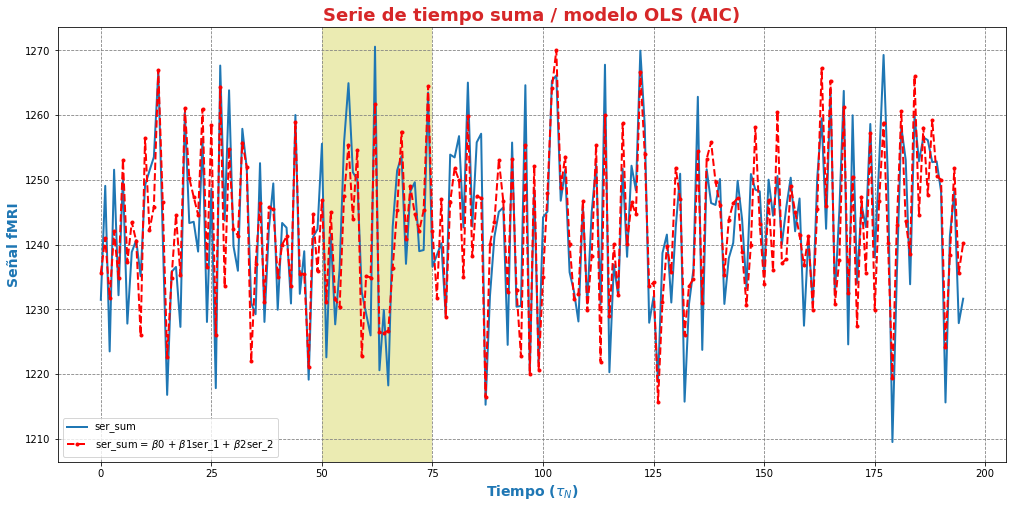

In [94]:
plot_series_osl(df_depen=df_suma, 
                models_osl=aic_all, 
                best=0, 
                titulo='Serie de tiempo suma / modelo OLS (AIC)', 
                name_save='serie_suma_model_ols_aic.png')

#### Graficamos la serie suma y el resultado del modelo que menos se ajusta mediante modelo de regresión OSL

                            OLS Regression Results                            
Dep. Variable:                ser_sum   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     1.551
Date:                Tue, 05 Jul 2022   Prob (F-statistic):              0.215
Time:                        01:03:58   Log-Likelihood:                -778.12
No. Observations:                 196   AIC:                             1562.
Df Residuals:                     193   BIC:                             1572.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1371.2942     77.944     17.593      0.0

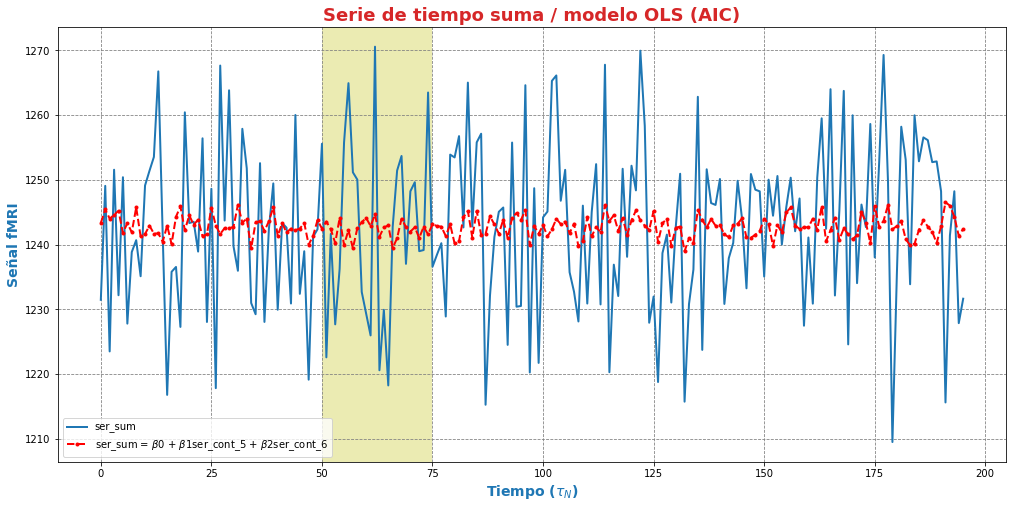

In [95]:
plot_series_osl(df_depen=df_suma, 
                models_osl=aic_all, 
                best=14, 
                titulo='Serie de tiempo suma / modelo OLS (AIC)', 
                name_save='serie_suma_model_ols_aic.png')

### Dataframe de comparacion de los modelos segun los estadisticos AIC, R2 Y R2 ajustado

In [96]:
compara_models_estad(aic=aic_all,
                     r2=r2_all,
                     r2_ajus=r2_ajus_all)

## Validación 5 / Regresión Lineal de series aleatorias


Usaremos el módulo statsmodels de Python para implementar el método Ordinary Least Squares( OLS ) de regresión lineal. Para la primera Validación, usaremos la data de *df_suma_random*, sin agregar series aleatorias adicionales.

Ahora vamos a 'contaminar' nuestros datos, agregando dos series aletorias que no son parte de la serie suma pero si seran parte de los modelos. La serie contaminante 7 (*ser_cont_7*) se encontrara se encontrara cerca y por encima de la *ser1* y a una distancia entre las medias de 5% x mean[mask_csf]; mientras que la serie contaminante 8 (*ser_cont_8*) se encontrara cerca y por debajo de *ser2* y a una distancia entre las medias de 5% x mean[mask_gm].

### Generamos series aleatorias contaminantes 7 y 8

In [97]:
np.random.seed(300)

# Creamos una serie por encima de ser 1

dif_7 = df_mean['mean']['ser_mask_csf']*0.05
mean_ser_cont_7 = df_mean['mean']['ser_mask_csf']+dif_7

ser_cont_7 = np.random.uniform(low= mean_ser_cont_7 - 15, 
                               high=mean_ser_cont_7 + 15, 
                               size=196).tolist()

#Creamos una serie por por debajo de ser2 pero arriba de error
dif_8 = df_mean['mean']['ser_mask_wm']*0.05
mean_ser_cont_8 = df_mean['mean']['ser_mask_wm']-dif_8

ser_cont_8 = np.random.uniform(low= mean_ser_cont_8 - 15, 
                               high=mean_ser_cont_8 + 15, 
                               size=196).tolist()

In [98]:
'''
Creamos DF de las series aleatorias contaminantes
'''
df_sr_con_7 = pd.DataFrame(ser_cont_7, columns=['ser_cont_7'])
df_sr_con_8 = pd.DataFrame(ser_cont_8, columns=['ser_cont_8'])

'''
Unimos DFs en una sola
'''
df_sr_conta_4 = pd.merge(df_sr_con_7, df_sr_con_8, right_index=True, left_index=True)
df_sr_conta_4.round(3)

ser_cont_7  ser_cont_8
0       637.101     515.723
1       630.198     507.357
2       634.640     513.249
3       632.291     511.614
4       630.800     508.338
..          ...         ...
191     623.736     506.311
192     628.456     504.959
193     638.439     506.937
194     643.923     523.118
195     637.160     522.335

[196 rows x 2 columns]

### Unimos series contaminantes con el dataframe de las series de prueba

In [99]:
df_valida_5 = pd.merge(df_suma_random, df_sr_conta_4, right_index=True, left_index=True)
df_valida_5.round(3)

ser_sum    ser_1    ser_2   error  ser_cont_7  ser_cont_8
0    1231.461  609.464  536.822  85.174     637.101     515.723
1    1249.067  614.456  537.631  96.981     630.198     507.357
2    1223.490  611.083  531.741  80.666     634.640     513.249
3    1251.559  609.346  543.032  99.180     632.291     511.614
4    1232.171  605.710  539.354  87.107     630.800     508.338
..        ...      ...      ...     ...         ...         ...
191  1215.607  599.295  534.782  81.530     623.736     506.311
192  1241.382  598.586  548.867  93.929     628.456     504.959
193  1248.232  621.331  541.953  84.948     638.439     506.937
194  1227.860  615.187  531.881  80.792     643.923     523.118
195  1231.634  607.714  542.721  81.199     637.160     522.335

[196 rows x 6 columns]

#### Damos un formato a las DF solo para ser extraidas a un documento

In [100]:
df_5 = df_valida_5.copy()

new_index = df_5.index+1

nomb_colum = df_5.columns.values

header = pd.MultiIndex.from_product([['Series de tiempo: '], nomb_colum],
                                    names=[' ','tiempo ($\\tau_N$)'])
df_5 = pd.DataFrame(df_5.values, columns=header, index=new_index)

display(df_5.round(3))

Series de tiempo:                                        \
tiempo ($\tau_N$)            ser_sum    ser_1    ser_2   error ser_cont_7   
1                           1231.461  609.464  536.822  85.174    637.101   
2                           1249.067  614.456  537.631  96.981    630.198   
3                           1223.490  611.083  531.741  80.666    634.640   
4                           1251.559  609.346  543.032  99.180    632.291   
5                           1232.171  605.710  539.354  87.107    630.800   
..                               ...      ...      ...     ...        ...   
192                         1215.607  599.295  534.782  81.530    623.736   
193                         1241.382  598.586  548.867  93.929    628.456   
194                         1248.232  621.331  541.953  84.948    638.439   
195                         1227.860  615.187  531.881  80.792    643.923   
196                         1231.634  607.714  542.721  81.199    637.160   

                              
tiempo ($\tau_N$) ser_cont_8  
1                    515.723  
2                    507.357  
3                    513.249  
4                    511.614  
5                    508.338  
..                       ...  
192                  506.311  
193                  504.959  
194                  506.937  
195                  523.118  
196                  522.335  

[196 rows x 6 columns]

### Graficamos las series

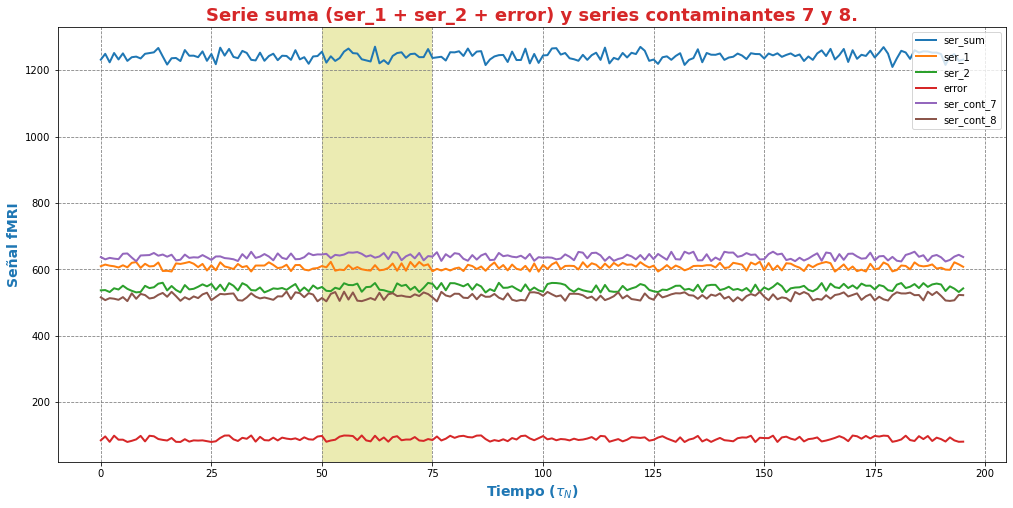

In [101]:
plot_series_time(df_data=df_valida_5, 
                 resaltar=['all'], 
                 titulo='Serie suma (ser_1 + ser_2 + error) y series contaminantes 7 y 8.', 
                 name_save='serie_suma_serie_conta?valida_2.png')

### Extraemos las combinaciones

Para extraer las posibles combinaciones o modelos que me pueden predecir la seria suma (*ser_sum*), en esta primera validación (asi como en las posteriores) no tomamos en cuenta en el modelo la serie error (*error*).

#### Lista de series que forman parte de las combinaciones ó modelos

Para extraer la lista que formaran parte de las combionaciones ó modelos, usamos la funcion *lista_dataframe*. Ahora, debemos tener claro que dataframe usaremos como input, para asi poder definir el input de la función *eliminar*. Por ejemplo, si usamos el dataframe *df_ser_random* y no queremos que la serie error sea parte del modelo, el input *eliminar* debe ser la lista *eliminar=['error']*; si usamos el dataframe *df_suma_random* y no queremos que la serie error sea parte del modelo, asi como la *ser_sum* ya que es la que queremos predecir, el input *eliminar* debe ser la lista *eliminar=['ser_sum', 'error']*

In [102]:
'''
Aplicamos funcion lista_dataframe
'''
list_ser = lista_dataframe(df=df_valida_5,
                           eliminar=['ser_sum','error'])

list_ser

['ser_1', 'ser_2', 'ser_cont_7', 'ser_cont_8']

#### Combinaciones de las series para generar ser_tiem_sum

In [103]:
'''
Posibles combinaciones de las series para generar ser_tiem_sum
'''
#ejecutamos funcion potencia
combi = potencia(list_ser)
combi

[[],
 ['ser_1'],
 ['ser_2'],
 ['ser_1', 'ser_2'],
 ['ser_cont_7'],
 ['ser_1', 'ser_cont_7'],
 ['ser_2', 'ser_cont_7'],
 ['ser_1', 'ser_2', 'ser_cont_7'],
 ['ser_cont_8'],
 ['ser_1', 'ser_cont_8'],
 ['ser_2', 'ser_cont_8'],
 ['ser_1', 'ser_2', 'ser_cont_8'],
 ['ser_cont_7', 'ser_cont_8'],
 ['ser_1', 'ser_cont_7', 'ser_cont_8'],
 ['ser_2', 'ser_cont_7', 'ser_cont_8'],
 ['ser_1', 'ser_2', 'ser_cont_7', 'ser_cont_8']]

Como al ejecutar la función potencia, entre los subconjuntos esta el conjunto vacio, lo eliminamos de nuestra lista

In [104]:
'''
Eliminamos primer elemento lista combi
'''
combi.pop(0)

print('posibles combinaciones de las series brain:\n', combi, '\n\n')

print('cantidad de combinaciones/modelos:\n\n', len(combi))

posibles combinaciones de las series brain:
 [['ser_1'], ['ser_2'], ['ser_1', 'ser_2'], ['ser_cont_7'], ['ser_1', 'ser_cont_7'], ['ser_2', 'ser_cont_7'], ['ser_1', 'ser_2', 'ser_cont_7'], ['ser_cont_8'], ['ser_1', 'ser_cont_8'], ['ser_2', 'ser_cont_8'], ['ser_1', 'ser_2', 'ser_cont_8'], ['ser_cont_7', 'ser_cont_8'], ['ser_1', 'ser_cont_7', 'ser_cont_8'], ['ser_2', 'ser_cont_7', 'ser_cont_8'], ['ser_1', 'ser_2', 'ser_cont_7', 'ser_cont_8']] 


cantidad de combinaciones/modelos:

 15


#### Generamos un DF de las combinaciones/modelos para un documento

In [105]:
pd.set_option( 'max_colwidth', 1)
crear_df_combi(lista_combi=combi, 
               columnas = 3)

Combinaciones / Modelos  \
   $\beta$0 + $\beta$1 ser_1                                                                
   $\beta$0 + $\beta$1 ser_1 + $\beta$2 ser_2 + $\beta$3 ser_cont_7 + $\beta$4 ser_cont_8   
   $\beta$0 + $\beta$1 ser_1 + $\beta$2 ser_cont_7 + $\beta$3 ser_cont_8                    
   $\beta$0 + $\beta$1 ser_2 + $\beta$2 ser_cont_7                                          
   $\beta$0 + $\beta$1 ser_cont_7                                                           

                                                 Combinaciones / Modelos  \
   $\beta$0 + $\beta$1 ser_1 + $\beta$2 ser_2                              
   $\beta$0 + $\beta$1 ser_1 + $\beta$2 ser_2 + $\beta$3 ser_cont_8        
   $\beta$0 + $\beta$1 ser_1 + $\beta$2 ser_cont_8                         
   $\beta$0 + $\beta$1 ser_2 + $\beta$2 ser_cont_7 + $\beta$3 ser_cont_8   
   $\beta$0 + $\beta$1 ser_cont_7 + $\beta$2 ser_cont_8                    

                                            Combinaciones / Modelos  
   $\beta$0 + $\beta$1 ser_1 + $\beta$2 ser_2 + $\beta$3 ser_cont_7  
   $\beta$0 + $\beta$1 ser_1 + $\beta$2 ser_cont_7                   
   $\beta$0 + $\beta$1 ser_2                                         
   $\beta$0 + $\beta$1 ser_2 + $\beta$2 ser_cont_8                   
   $\beta$0 + $\beta$1 ser_cont_8

### Aplicamos el modelo OLS

In [106]:
'''
Creamos DF con las series independientes
'''
df_ser_indep = df_valida_5.drop(['ser_sum','error'], axis=1)
df_ser_indep

ser_1       ser_2  ser_cont_7  ser_cont_8
0    609.464405  536.822439  637.101018  515.723270
1    614.455681  537.630694  630.198012  507.356907
2    611.082901  531.740875  634.639779  513.249412
3    609.346495  543.032499  632.290613  511.613755
4    605.709644  539.353876  630.799679  508.337658
..          ...         ...         ...         ...
191  599.295312  534.782434  623.735931  506.311234
192  598.585790  548.866953  628.455680  504.959196
193  621.331172  541.953028  638.438789  506.937433
194  615.186524  531.881389  643.922711  523.117773
195  607.713764  542.720968  637.160307  522.334792

[196 rows x 4 columns]

#### Ejecutamos la función  *best_osl*  para determinar el mejor modelo mediante modelo de regresión OSL

In [107]:
modelo_regre = best_osl(df_depen=df_suma, 
                        df_indep=df_ser_indep, 
                        var_depen='ser_sum',
                        lista_combi=combi)

In [108]:
mejor_aic = modelo_regre[0]
aic_all = modelo_regre[1]
mejor_r2 = modelo_regre[2]
r2_all = modelo_regre[3]
mejor_r2_ajus = modelo_regre[4]
r2_ajus_all = modelo_regre[5]

In [109]:
mejor_aic

serie       MODELO      AIC  \
0  0      ser_1,ser_2  1263.62   

                                                                       resultado_regresión  
0  <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f60da48ce80>

In [110]:
pd.set_option('display.max_colwidth', 60)
aic_all

serie                             MODELO      AIC  \
0       0                        ser_1,ser_2  1263.62   
1       0             ser_1,ser_2,ser_cont_8  1264.84   
2       0             ser_1,ser_2,ser_cont_7  1265.17   
3       0  ser_1,ser_2,ser_cont_7,ser_cont_8  1266.46   
4       0        ser_2,ser_cont_7,ser_cont_8  1450.73   
5       0                   ser_2,ser_cont_8  1451.12   
6       0                   ser_2,ser_cont_7  1453.73   
7       0                              ser_2  1453.79   
8       0                              ser_1  1497.42   
9       0                   ser_1,ser_cont_8  1499.41   
10      0                   ser_1,ser_cont_7  1499.42   
11      0        ser_1,ser_cont_7,ser_cont_8  1501.41   
12      0                         ser_cont_7  1561.81   
13      0                         ser_cont_8  1561.93   
14      0              ser_cont_7,ser_cont_8  1562.24   

                                            resultado_regresión  
0   <statsmodels.regression.linear_model.RegressionResultsWr...  
1   <statsmodels.regression.linear_model.RegressionResultsWr...  
2   <statsmodels.regression.linear_model.RegressionResultsWr...  
3   <statsmodels.regression.linear_model.RegressionResultsWr...  
4   <statsmodels.regression.linear_model.RegressionResultsWr...  
5   <statsmodels.regression.linear_model.RegressionResultsWr...  
6   <statsmodels.regression.linear_model.RegressionResultsWr...  
7   <statsmodels.regression.linear_model.RegressionResultsWr...  
8   <statsmodels.regression.linear_model.RegressionResultsWr...  
9   <statsmodels.regression.linear_model.RegressionResultsWr...  
10  <statsmodels.regression.linear_model.RegressionResultsWr...  
11  <statsmodels.regression.linear_model.RegressionResultsWr...  
12  <statsmodels.regression.linear_model.RegressionResultsWr...  
13  <statsmodels.regression.linear_model.RegressionResultsWr...  
14  <statsmodels.regression.linear_model.RegressionResultsWr...

#### Aplicamos función *analisi_p* para extraer los valores p de los regresores, y confirmar mejor modelo

In [111]:
analisi_p(df_anali=mejor_aic, 
          nivel_signif=0.05)

serie       MODELO      AIC  const  ser_1  ser_2 valores_p_regresores  \
0      0  ser_1,ser_2  1263.62   0.01    0.0    0.0     [0.01, 0.0, 0.0]   

   suma_evaluación     MODELO_P  
0                0  ser_1,ser_2

#### Graficamos la serie suma y el resultado del mejor modelo mediante modelo de regresión OSL

                            OLS Regression Results                            
Dep. Variable:                ser_sum   R-squared:                       0.786
Model:                            OLS   Adj. R-squared:                  0.783
Method:                 Least Squares   F-statistic:                     353.4
Date:                Tue, 05 Jul 2022   Prob (F-statistic):           3.03e-65
Time:                        01:04:01   Log-Likelihood:                -628.81
No. Observations:                 196   AIC:                             1264.
Df Residuals:                     193   BIC:                             1273.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        116.3428     42.874      2.714      0.0

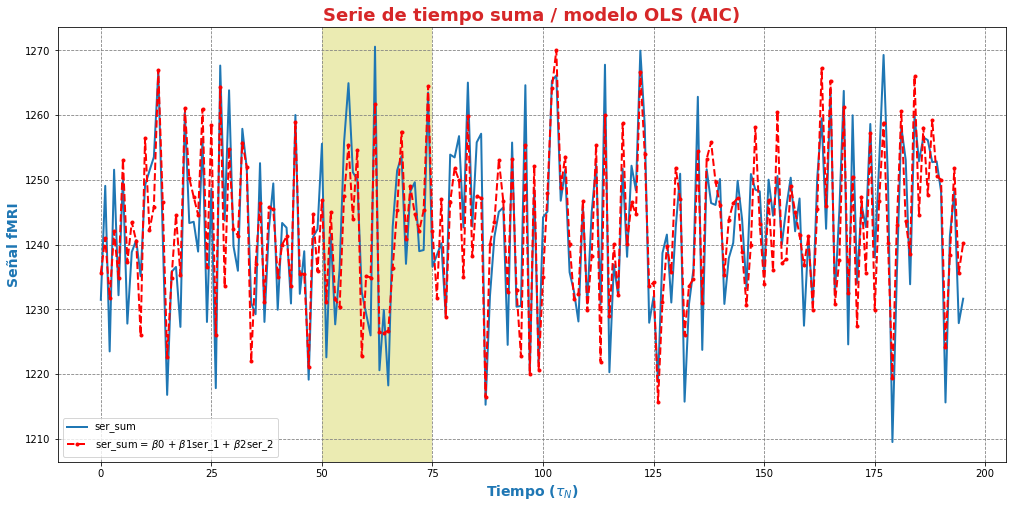

In [112]:
plot_series_osl(df_depen=df_suma, 
                models_osl=aic_all, 
                best=0, 
                titulo='Serie de tiempo suma / modelo OLS (AIC)', 
                name_save='serie_suma_model_ols_aic.png')

#### Graficamos la serie suma y el resultado del modelo que menos se ajusta mediante modelo de regresión OSL

                            OLS Regression Results                            
Dep. Variable:                ser_sum   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     1.551
Date:                Tue, 05 Jul 2022   Prob (F-statistic):              0.215
Time:                        01:04:01   Log-Likelihood:                -778.12
No. Observations:                 196   AIC:                             1562.
Df Residuals:                     193   BIC:                             1572.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1404.3399     92.164     15.237      0.0

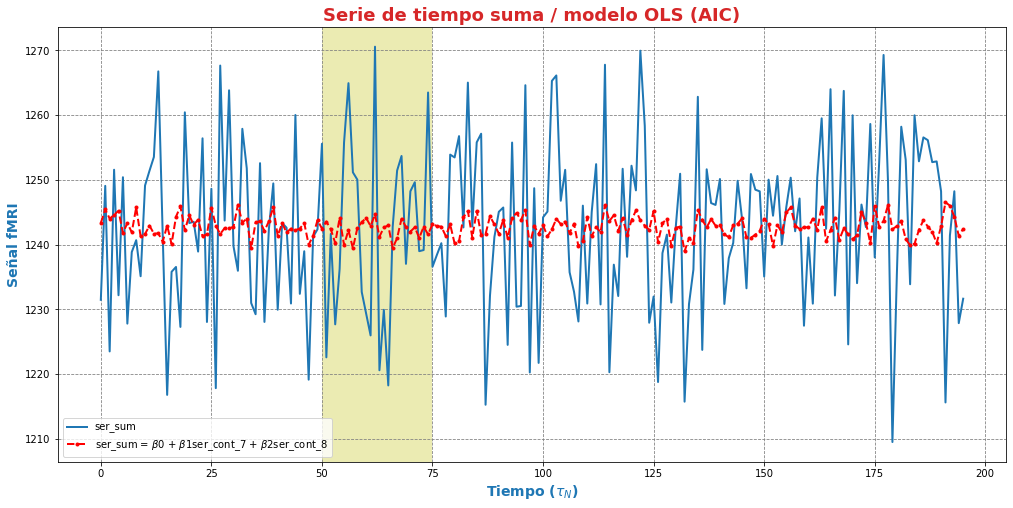

In [113]:
plot_series_osl(df_depen=df_suma, 
                models_osl=aic_all, 
                best=14, 
                titulo='Serie de tiempo suma / modelo OLS (AIC)', 
                name_save='serie_suma_model_ols_aic.png')

### Dataframe de comparacion de los modelos segun los estadisticos AIC, R2 Y R2 ajustado

In [114]:
compara_models_estad(aic=aic_all,
                     r2=r2_all,
                     r2_ajus=r2_ajus_all)

## Validación 6 / Regresión Lineal de series aleatorias


Usaremos el módulo statsmodels de Python para implementar el método Ordinary Least Squares( OLS ) de regresión lineal. Para la primera Validación, usaremos la data de *df_suma_random*, sin agregar series aleatorias adicionales.

Ahora vamos a 'contaminar' nuestros datos, agregando cuatro series aletorias que no son parte de la serie suma pero si seran parte de los modelos. Las series contaminantes a utilizar son las ya generadas, como *ser_cont_1*, *ser_cont_2*, *ser_cont_4* y *ser_cont_5*.

### Creamos Dataframe de las series contamninantes

In [115]:
'''
Unimos DFs en una sola
'''
df_sr_conta_5_sub1 = pd.merge(df_sr_con_1, df_sr_con_2, right_index=True, left_index=True)
df_sr_conta_5_sub2 = pd.merge(df_sr_con_4, df_sr_con_5, right_index=True, left_index=True)

df_sr_conta_5 = pd.merge(df_sr_conta_5_sub1, df_sr_conta_5_sub2, right_index=True, left_index=True)
df_sr_conta_5

ser_cont_1  ser_cont_2  ser_cont_4  ser_cont_5
0    925.668027  271.298954  515.723270  637.101018
1    904.035482  267.939318  507.356907  630.198012
2    915.071664  266.834516  513.249412  634.639779
3    910.088320  287.142214  511.613755  632.290613
4    920.163280  265.424289  508.337658  630.799679
..          ...         ...         ...         ...
191  899.245218  276.771131  506.311234  623.735931
192  897.854431  262.901252  504.959196  628.455680
193  922.537340  269.127536  506.937433  638.438789
194  924.805534  264.257052  523.117773  643.922711
195  898.941225  286.741797  522.334792  637.160307

[196 rows x 4 columns]

### Unimos series contaminantes con el dataframe de las series de prueba

In [116]:
df_valida_6 = pd.merge(df_suma_random, df_sr_conta_5, right_index=True, left_index=True)
df_valida_6.round(3)

ser_sum    ser_1    ser_2   error  ser_cont_1  ser_cont_2  ser_cont_4  \
0    1231.461  609.464  536.822  85.174     925.668     271.299     515.723   
1    1249.067  614.456  537.631  96.981     904.035     267.939     507.357   
2    1223.490  611.083  531.741  80.666     915.072     266.835     513.249   
3    1251.559  609.346  543.032  99.180     910.088     287.142     511.614   
4    1232.171  605.710  539.354  87.107     920.163     265.424     508.338   
..        ...      ...      ...     ...         ...         ...         ...   
191  1215.607  599.295  534.782  81.530     899.245     276.771     506.311   
192  1241.382  598.586  548.867  93.929     897.854     262.901     504.959   
193  1248.232  621.331  541.953  84.948     922.537     269.128     506.937   
194  1227.860  615.187  531.881  80.792     924.806     264.257     523.118   
195  1231.634  607.714  542.721  81.199     898.941     286.742     522.335   

     ser_cont_5  
0       637.101  
1       630.198  
2       634.640  
3       632.291  
4       630.800  
..          ...  
191     623.736  
192     628.456  
193     638.439  
194     643.923  
195     637.160  

[196 rows x 8 columns]

#### Damos un formato a las DF solo para ser extraidas a un documento

In [117]:
df_6 = df_valida_6.copy()

new_index = df_6.index+1

nomb_colum = df_6.columns.values

header = pd.MultiIndex.from_product([['Series de tiempo: '], nomb_colum],
                                    names=[' ','tiempo ($\\tau_N$)'])
df_6 = pd.DataFrame(df_6.values, columns=header, index=new_index)

display(df_6.round(3))

Series de tiempo:                                        \
tiempo ($\tau_N$)            ser_sum    ser_1    ser_2   error ser_cont_1   
1                           1231.461  609.464  536.822  85.174    925.668   
2                           1249.067  614.456  537.631  96.981    904.035   
3                           1223.490  611.083  531.741  80.666    915.072   
4                           1251.559  609.346  543.032  99.180    910.088   
5                           1232.171  605.710  539.354  87.107    920.163   
..                               ...      ...      ...     ...        ...   
192                         1215.607  599.295  534.782  81.530    899.245   
193                         1241.382  598.586  548.867  93.929    897.854   
194                         1248.232  621.331  541.953  84.948    922.537   
195                         1227.860  615.187  531.881  80.792    924.806   
196                         1231.634  607.714  542.721  81.199    898.941   

                                                    
tiempo ($\tau_N$) ser_cont_2 ser_cont_4 ser_cont_5  
1                    271.299    515.723    637.101  
2                    267.939    507.357    630.198  
3                    266.835    513.249    634.640  
4                    287.142    511.614    632.291  
5                    265.424    508.338    630.800  
..                       ...        ...        ...  
192                  276.771    506.311    623.736  
193                  262.901    504.959    628.456  
194                  269.128    506.937    638.439  
195                  264.257    523.118    643.923  
196                  286.742    522.335    637.160  

[196 rows x 8 columns]

### Graficamos las series

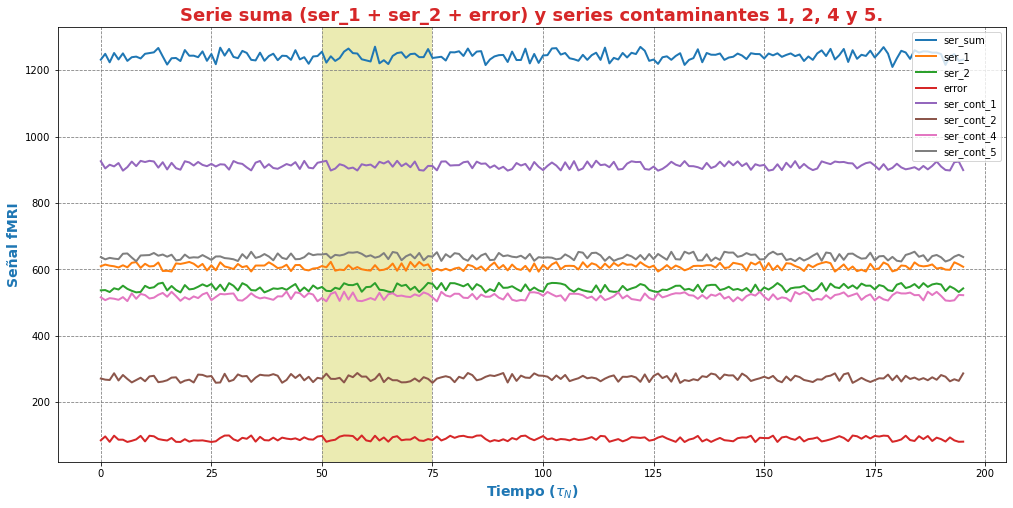

In [118]:
plot_series_time(df_data=df_valida_6, 
                 resaltar=['all'], 
                 titulo='Serie suma (ser_1 + ser_2 + error) y series contaminantes 1, 2, 4 y 5.', 
                 name_save='serie_suma_serie_conta?valida_2.png')

### Extraemos las combinaciones

Para extraer las posibles combinaciones o modelos que me pueden predecir la seria suma (*ser_sum*), en esta primera validación (asi como en las posteriores) no tomamos en cuenta en el modelo la serie error (*error*).

#### Lista de series que forman parte de las combinaciones ó modelos

Para extraer la lista que formaran parte de las combionaciones ó modelos, usamos la funcion *lista_dataframe*. Ahora, debemos tener claro que dataframe usaremos como input, para asi poder definir el input de la función *eliminar*. Por ejemplo, si usamos el dataframe *df_ser_random* y no queremos que la serie error sea parte del modelo, el input *eliminar* debe ser la lista *eliminar=['error']*; si usamos el dataframe *df_suma_random* y no queremos que la serie error sea parte del modelo, asi como la *ser_sum* ya que es la que queremos predecir, el input *eliminar* debe ser la lista *eliminar=['ser_sum', 'error']*

In [119]:
'''
Aplicamos funcion lista_dataframe
'''
list_ser = lista_dataframe(df=df_valida_6,
                           eliminar=['ser_sum','error'])

list_ser

['ser_1', 'ser_2', 'ser_cont_1', 'ser_cont_2', 'ser_cont_4', 'ser_cont_5']

#### Combinaciones de las series para generar ser_tiem_sum

In [120]:
'''
Posibles combinaciones de las series para generar ser_tiem_sum
'''
#ejecutamos funcion potencia
combi = potencia(list_ser)
combi

[[],
 ['ser_1'],
 ['ser_2'],
 ['ser_1', 'ser_2'],
 ['ser_cont_1'],
 ['ser_1', 'ser_cont_1'],
 ['ser_2', 'ser_cont_1'],
 ['ser_1', 'ser_2', 'ser_cont_1'],
 ['ser_cont_2'],
 ['ser_1', 'ser_cont_2'],
 ['ser_2', 'ser_cont_2'],
 ['ser_1', 'ser_2', 'ser_cont_2'],
 ['ser_cont_1', 'ser_cont_2'],
 ['ser_1', 'ser_cont_1', 'ser_cont_2'],
 ['ser_2', 'ser_cont_1', 'ser_cont_2'],
 ['ser_1', 'ser_2', 'ser_cont_1', 'ser_cont_2'],
 ['ser_cont_4'],
 ['ser_1', 'ser_cont_4'],
 ['ser_2', 'ser_cont_4'],
 ['ser_1', 'ser_2', 'ser_cont_4'],
 ['ser_cont_1', 'ser_cont_4'],
 ['ser_1', 'ser_cont_1', 'ser_cont_4'],
 ['ser_2', 'ser_cont_1', 'ser_cont_4'],
 ['ser_1', 'ser_2', 'ser_cont_1', 'ser_cont_4'],
 ['ser_cont_2', 'ser_cont_4'],
 ['ser_1', 'ser_cont_2', 'ser_cont_4'],
 ['ser_2', 'ser_cont_2', 'ser_cont_4'],
 ['ser_1', 'ser_2', 'ser_cont_2', 'ser_cont_4'],
 ['ser_cont_1', 'ser_cont_2', 'ser_cont_4'],
 ['ser_1', 'ser_cont_1', 'ser_cont_2', 'ser_cont_4'],
 ['ser_2', 'ser_cont_1', 'ser_cont_2', 'ser_cont_4'],
 ['se

Como al ejecutar la función potencia, entre los subconjuntos esta el conjunto vacio, lo eliminamos de nuestra lista

In [121]:
'''
Eliminamos primer elemento lista combi
'''
combi.pop(0)

print('posibles combinaciones de las series brain:\n', combi, '\n\n')

print('cantidad de combinaciones/modelos:\n\n', len(combi))

posibles combinaciones de las series brain:
 [['ser_1'], ['ser_2'], ['ser_1', 'ser_2'], ['ser_cont_1'], ['ser_1', 'ser_cont_1'], ['ser_2', 'ser_cont_1'], ['ser_1', 'ser_2', 'ser_cont_1'], ['ser_cont_2'], ['ser_1', 'ser_cont_2'], ['ser_2', 'ser_cont_2'], ['ser_1', 'ser_2', 'ser_cont_2'], ['ser_cont_1', 'ser_cont_2'], ['ser_1', 'ser_cont_1', 'ser_cont_2'], ['ser_2', 'ser_cont_1', 'ser_cont_2'], ['ser_1', 'ser_2', 'ser_cont_1', 'ser_cont_2'], ['ser_cont_4'], ['ser_1', 'ser_cont_4'], ['ser_2', 'ser_cont_4'], ['ser_1', 'ser_2', 'ser_cont_4'], ['ser_cont_1', 'ser_cont_4'], ['ser_1', 'ser_cont_1', 'ser_cont_4'], ['ser_2', 'ser_cont_1', 'ser_cont_4'], ['ser_1', 'ser_2', 'ser_cont_1', 'ser_cont_4'], ['ser_cont_2', 'ser_cont_4'], ['ser_1', 'ser_cont_2', 'ser_cont_4'], ['ser_2', 'ser_cont_2', 'ser_cont_4'], ['ser_1', 'ser_2', 'ser_cont_2', 'ser_cont_4'], ['ser_cont_1', 'ser_cont_2', 'ser_cont_4'], ['ser_1', 'ser_cont_1', 'ser_cont_2', 'ser_cont_4'], ['ser_2', 'ser_cont_1', 'ser_cont_2', 'ser_cont

#### Generamos un DF de las combinaciones/modelos para un documento

In [122]:
pd.set_option( 'max_colwidth', 1)

crear_df_combi(lista_combi=combi, 
               columnas = 3)

Combinaciones / Modelos  \
   $\beta$0 + $\beta$1 ser_1                                                                                           
   $\beta$0 + $\beta$1 ser_1 + $\beta$2 ser_2 + $\beta$3 ser_cont_1 + $\beta$4 ser_cont_2                              
   $\beta$0 + $\beta$1 ser_1 + $\beta$2 ser_2 + $\beta$3 ser_cont_1 + $\beta$4 ser_cont_2 + $\beta$5 ser_cont_5        
   $\beta$0 + $\beta$1 ser_1 + $\beta$2 ser_2 + $\beta$3 ser_cont_1 + $\beta$4 ser_cont_5                              
   $\beta$0 + $\beta$1 ser_1 + $\beta$2 ser_2 + $\beta$3 ser_cont_2 + $\beta$4 ser_cont_4 + $\beta$5 ser_cont_5        
   $\beta$0 + $\beta$1 ser_1 + $\beta$2 ser_2 + $\beta$3 ser_cont_4 + $\beta$4 ser_cont_5                              
   $\beta$0 + $\beta$1 ser_1 + $\beta$2 ser_cont_1 + $\beta$3 ser_cont_2                                               
   $\beta$0 + $\beta$1 ser_1 + $\beta$2 ser_cont_1 + $\beta$3 ser_cont_2 + $\beta$4 ser_cont_5                         
   $\beta$0 + $\beta$1 ser_1 + $\beta$2 ser_cont_1 + $\beta$3 ser_cont_5                                               
   $\beta$0 + $\beta$1 ser_1 + $\beta$2 ser_cont_2 + $\beta$3 ser_cont_4 + $\beta$4 ser_cont_5                         
   $\beta$0 + $\beta$1 ser_1 + $\beta$2 ser_cont_4 + $\beta$3 ser_cont_5                                               
   $\beta$0 + $\beta$1 ser_2 + $\beta$2 ser_cont_1                                                                     
   $\beta$0 + $\beta$1 ser_2 + $\beta$2 ser_cont_1 + $\beta$3 ser_cont_2 + $\beta$4 ser_cont_4 + $\beta$5 ser_cont_5   
   $\beta$0 + $\beta$1 ser_2 + $\beta$2 ser_cont_1 + $\beta$3 ser_cont_4 + $\beta$4 ser_cont_5                         
   $\beta$0 + $\beta$1 ser_2 + $\beta$2 ser_cont_2 + $\beta$3 ser_cont_4                                               
   $\beta$0 + $\beta$1 ser_2 + $\beta$2 ser_cont_4                                                                     
   $\beta$0 + $\beta$1 ser_cont_1                                                                                      
   $\beta$0 + $\beta$1 ser_cont_1 + $\beta$2 ser_cont_2 + $\beta$3 ser_cont_4 + $\beta$4 ser_cont_5                    
   $\beta$0 + $\beta$1 ser_cont_1 + $\beta$2 ser_cont_4 + $\beta$3 ser_cont_5                                          
   $\beta$0 + $\beta$1 ser_cont_2 + $\beta$2 ser_cont_4                                                                
   $\beta$0 + $\beta$1 ser_cont_4                                                                                      

                                                                                        Combinaciones / Modelos  \
   $\beta$0 + $\beta$1 ser_1 + $\beta$2 ser_2                                                                     
   $\beta$0 + $\beta$1 ser_1 + $\beta$2 ser_2 + $\beta$3 ser_cont_1 + $\beta$4 ser_cont_2 + $\beta$5 ser_cont_4   
   $\beta$0 + $\beta$1 ser_1 + $\beta$2 ser_2 + $\beta$3 ser_cont_1 + $\beta$4 ser_cont_4                         
   $\beta$0 + $\beta$1 ser_1 + $\beta$2 ser_2 + $\beta$3 ser_cont_2                                               
   $\beta$0 + $\beta$1 ser_1 + $\beta$2 ser_2 + $\beta$3 ser_cont_2 + $\beta$4 ser_cont_5                         
   $\beta$0 + $\beta$1 ser_1 + $\beta$2 ser_2 + $\beta$3 ser_cont_5                                               
   $\beta$0 + $\beta$1 ser_1 + $\beta$2 ser_cont_1 + $\beta$3 ser_cont_2 + $\beta$4 ser_cont_4                    
   $\beta$0 + $\beta$1 ser_1 + $\beta$2 ser_cont_1 + $\beta$3 ser_cont_4                                          
   $\beta$0 + $\beta$1 ser_1 + $\beta$2 ser_cont_2                                                                
   $\beta$0 + $\beta$1 ser_1 + $\beta$2 ser_cont_2 + $\beta$3 ser_cont_5                                          
   $\beta$0 + $\beta$1 ser_1 + $\beta$2 ser_cont_5                                                                
   $\beta$0 + $\beta$1 ser_2 + $\beta$2 ser_cont_1 + $\beta$3 ser_cont_2

### Aplicamos el modelo OLS

In [123]:
'''
Creamos DF con las series independientes
'''
df_ser_indep = df_valida_6.drop(['ser_sum','error'], axis=1)
df_ser_indep

ser_1       ser_2  ser_cont_1  ser_cont_2  ser_cont_4  ser_cont_5
0    609.464405  536.822439  925.668027  271.298954  515.723270  637.101018
1    614.455681  537.630694  904.035482  267.939318  507.356907  630.198012
2    611.082901  531.740875  915.071664  266.834516  513.249412  634.639779
3    609.346495  543.032499  910.088320  287.142214  511.613755  632.290613
4    605.709644  539.353876  920.163280  265.424289  508.337658  630.799679
..          ...         ...         ...         ...         ...         ...
191  599.295312  534.782434  899.245218  276.771131  506.311234  623.735931
192  598.585790  548.866953  897.854431  262.901252  504.959196  628.455680
193  621.331172  541.953028  922.537340  269.127536  506.937433  638.438789
194  615.186524  531.881389  924.805534  264.257052  523.117773  643.922711
195  607.713764  542.720968  898.941225  286.741797  522.334792  637.160307

[196 rows x 6 columns]

#### Ejecutamos la función  *best_osl*  para determinar el mejor modelo mediante modelo de regresión OSL

In [124]:
modelo_regre = best_osl(df_depen=df_suma, 
                        df_indep=df_ser_indep, 
                        var_depen='ser_sum',
                        lista_combi=combi)

In [125]:
mejor_aic = modelo_regre[0]
aic_all = modelo_regre[1]
mejor_r2 = modelo_regre[2]
r2_all = modelo_regre[3]
mejor_r2_ajus = modelo_regre[4]
r2_ajus_all = modelo_regre[5]

In [126]:
mejor_aic

serie       MODELO      AIC  \
0  0      ser_1,ser_2  1263.62   

                                                                       resultado_regresión  
0  <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f60d8ae51c0>

In [127]:
pd.set_option('display.max_colwidth', 60)
f=aic_all
f

serie                                       MODELO      AIC  \
0       0                                  ser_1,ser_2  1263.62   
1       0                       ser_1,ser_2,ser_cont_4  1264.84   
2       0                       ser_1,ser_2,ser_cont_2  1265.02   
3       0                       ser_1,ser_2,ser_cont_5  1265.17   
4       0                       ser_1,ser_2,ser_cont_1  1265.48   
..    ...                                          ...      ...   
58      0                        ser_cont_2,ser_cont_4  1563.69   
59      0             ser_cont_1,ser_cont_2,ser_cont_4  1563.74   
60      0             ser_cont_1,ser_cont_2,ser_cont_5  1563.76   
61      0             ser_cont_2,ser_cont_4,ser_cont_5  1563.87   
62      0  ser_cont_1,ser_cont_2,ser_cont_4,ser_cont_5  1564.13   

                                            resultado_regresión  
0   <statsmodels.regression.linear_model.RegressionResultsWr...  
1   <statsmodels.regression.linear_model.RegressionResultsWr...  
2   <statsmodels.regression.linear_model.RegressionResultsWr...  
3   <statsmodels.regression.linear_model.RegressionResultsWr...  
4   <statsmodels.regression.linear_model.RegressionResultsWr...  
..                                                          ...  
58  <statsmodels.regression.linear_model.RegressionResultsWr...  
59  <statsmodels.regression.linear_model.RegressionResultsWr...  
60  <statsmodels.regression.linear_model.RegressionResultsWr...  
61  <statsmodels.regression.linear_model.RegressionResultsWr...  
62  <statsmodels.regression.linear_model.RegressionResultsWr...  

[63 rows x 4 columns]

In [128]:
#pd.options.display.max_rows = 30
#pd.set_option('display.max_rows', 40) 
pd.set_option('max_rows', 30)
f

serie                                       MODELO      AIC  \
0       0                                  ser_1,ser_2  1263.62   
1       0                       ser_1,ser_2,ser_cont_4  1264.84   
2       0                       ser_1,ser_2,ser_cont_2  1265.02   
3       0                       ser_1,ser_2,ser_cont_5  1265.17   
4       0                       ser_1,ser_2,ser_cont_1  1265.48   
..    ...                                          ...      ...   
58      0                        ser_cont_2,ser_cont_4  1563.69   
59      0             ser_cont_1,ser_cont_2,ser_cont_4  1563.74   
60      0             ser_cont_1,ser_cont_2,ser_cont_5  1563.76   
61      0             ser_cont_2,ser_cont_4,ser_cont_5  1563.87   
62      0  ser_cont_1,ser_cont_2,ser_cont_4,ser_cont_5  1564.13   

                                            resultado_regresión  
0   <statsmodels.regression.linear_model.RegressionResultsWr...  
1   <statsmodels.regression.linear_model.RegressionResultsWr...  
2   <statsmodels.regression.linear_model.RegressionResultsWr...  
3   <statsmodels.regression.linear_model.RegressionResultsWr...  
4   <statsmodels.regression.linear_model.RegressionResultsWr...  
..                                                          ...  
58  <statsmodels.regression.linear_model.RegressionResultsWr...  
59  <statsmodels.regression.linear_model.RegressionResultsWr...  
60  <statsmodels.regression.linear_model.RegressionResultsWr...  
61  <statsmodels.regression.linear_model.RegressionResultsWr...  
62  <statsmodels.regression.linear_model.RegressionResultsWr...  

[63 rows x 4 columns]

#### Aplicamos función *analisi_p* para extraer los valores p de los regresores, y confirmar mejor modelo

In [129]:
analisi_p(df_anali=mejor_aic, 
          nivel_signif=0.05)

serie       MODELO      AIC  const  ser_1  ser_2 valores_p_regresores  \
0      0  ser_1,ser_2  1263.62   0.01    0.0    0.0     [0.01, 0.0, 0.0]   

   suma_evaluación     MODELO_P  
0                0  ser_1,ser_2

#### Graficamos la serie suma y el resultado del mejor modelo mediante modelo de regresión OSL

                            OLS Regression Results                            
Dep. Variable:                ser_sum   R-squared:                       0.786
Model:                            OLS   Adj. R-squared:                  0.783
Method:                 Least Squares   F-statistic:                     353.4
Date:                Tue, 05 Jul 2022   Prob (F-statistic):           3.03e-65
Time:                        01:04:04   Log-Likelihood:                -628.81
No. Observations:                 196   AIC:                             1264.
Df Residuals:                     193   BIC:                             1273.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        116.3428     42.874      2.714      0.0

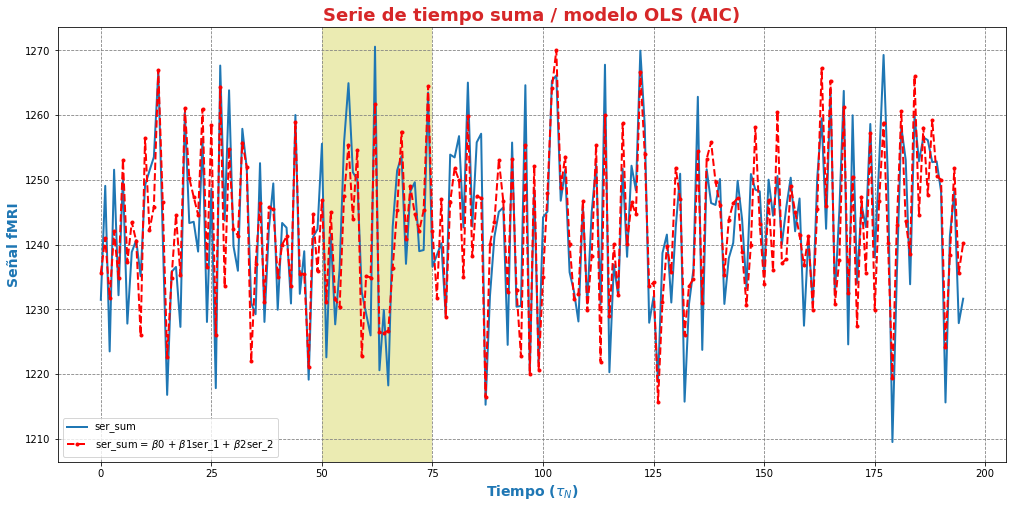

In [130]:
plot_series_osl(df_depen=df_suma, 
                models_osl=aic_all, 
                best=0, 
                titulo='Serie de tiempo suma / modelo OLS (AIC)', 
                name_save='serie_suma_model_ols_aic.png')

#### Graficamos la serie suma y el resultado del modelo que menos se ajusta mediante modelo de regresión OSL

                            OLS Regression Results                            
Dep. Variable:                ser_sum   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     1.293
Date:                Tue, 05 Jul 2022   Prob (F-statistic):              0.274
Time:                        01:04:04   Log-Likelihood:                -777.06
No. Observations:                 196   AIC:                             1564.
Df Residuals:                     191   BIC:                             1581.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1302.6608    140.791      9.252      0.0

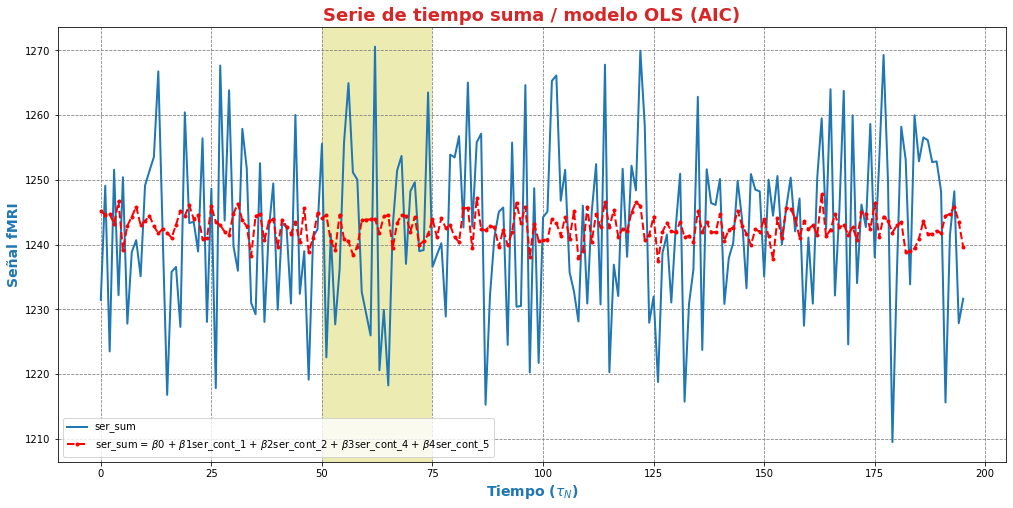

In [131]:
plot_series_osl(df_depen=df_suma, 
                models_osl=aic_all, 
                best=62, 
                titulo='Serie de tiempo suma / modelo OLS (AIC)', 
                name_save='serie_suma_model_ols_aic.png')

### Dataframe de comparacion de los modelos segun los estadisticos AIC, R2 Y R2 ajustado

In [132]:
compara_models_estad(aic=aic_all,
                     r2=r2_all,
                     r2_ajus=r2_ajus_all)

## Tiempo de ejecución

In [133]:
fin = time.time()
end = time.process_time()
tiempo = fin - inicio
tiempo2 = end - start

print('-----------------------------\n', 
      'tiempo de ejecución\n\n', tiempo, 'seg\n', tiempo/60, 'min\n',      
     '-----------------------------\n')
print('---------------------------------------\n', 
      'tiempo de ejecución del sistema y CPU\n\n', tiempo2, 'seg\n', tiempo2/60, 'min\n',   
     '---------------------------------------\n')

-----------------------------
 tiempo de ejecución

 23.443130254745483 seg
 0.39071883757909137 min
 -----------------------------

---------------------------------------
 tiempo de ejecución del sistema y CPU

 17.020817958 seg
 0.2836802993 min
 ---------------------------------------



## FIN